# Preprocessing Step
---

This notebook carrieds out the preprocessing steps for the metabolomics data.

## Input

### Libraries

If it the first time running this notebook and the `Manifest.toml` is missing in the main directory or some packages are not installed, it is necessary to instantiate. It will create a `Manifest.toml` file, based on the`Project.toml` which contains all necessary package references to run the preprocessing pipeline. Then it will automatically download all the packages declared in that manifest and the project will be precompiled.  

In [1]:
isManifestexist = false # change to true to download and install all necessary packages

if isManifestexist 
    using Pkg
    Pkg.instantiate()
end

If RCall is used for the first time, one needs to indicate the location of the R home directory.

In [2]:
firstTimeRCall = false # change to true if it is the first time using RCall

if firstTimeRCall 
    ENV["R_HOME"] = "C:/PROGRA~1/R/R-41~1.2" # path obtained from R.home() in R
    using Pkg
    Pkg.build("RCall")
end     

Load libraries

In [3]:
using CSV, DataFrames, Missings, CategoricalArrays
using StatsBase, Statistics, MultivariateStats, GLM
using RCall
using FreqTables, Plots, StatsPlots

In [4]:
# Change display options
Base.displaysize() = (280, 88)

### Ext. Functions

In [5]:
include(joinpath(@__DIR__,"..","..","src","preprocessing.jl" ));
include(joinpath(@__DIR__,"..","..","src","utils.jl" ));

### Load data

In [6]:
# Load Negative
negMeta = realpath((@__DIR__)*"/../../data/data_primary/Elam_metabolites_2020_NEG_PH_cleaned_blkfil-batch-effect-analysis.csv")
dfNegMeta = DataFrame(CSV.File(negMeta));

negMetaKln = realpath((@__DIR__)*"/../../data/data_primary/Elam_metabolites-negative-2020_batch-corrected-all-data-elements.csv")
dfNegMetaKln = DataFrame(CSV.File(negMetaKln));

# Load Positive
posMeta = realpath(joinpath(@__DIR__,"..", "..","data","data_primary","Elam_metabolites_2020_POS_PH_cleaned_blkfil-batch-effect-analysis.csv" ))
dfPosMeta = DataFrame(CSV.File(posMeta));

posMetaKln = realpath(joinpath(@__DIR__,"..", "..","data","data_primary","Elam_metabolites-positive-2020_batch-corrected-all-data-elements.csv" ))
dfPosMetaKln = DataFrame(CSV.File(posMetaKln));

## Chain of preprocessing

Wrangle => Imputation => Normalization => Log2 Transformation => Batch Effect Correction

## Wrangle data
----

### Metabolites reference dictionnary

We create a reference dictionnary for the metabolites name.

In [7]:
first(dfNegMeta)

Row,Sample,Group,Batch,Column4,PYRUVATE_221.0301-1.37,CITRATE_173.0086-1.93,L-ASPARAGINE_113.0355-0.77,DEHYDROASCORBATE_173.0085-1.27,CITRATE_213.0017-1.96,HOMOVANILLATE_181.0526-8.41,XANTHOSINE_283.0681-6.53,METHYLMALONATE_257.0280-2.49,HYPOTAURINE_239.0139-0.76,3-HYDROXY-3-METHYLGLUTARATE_183.0272-2.98,URACIL_111.0201-1.34,SHIKIMATE_219.0514-1.08,URACIL_111.0201-1.41,TAURINE_249.0224-0.79,PYRIDOXAMINE_213.0856-0.68,SHIKIMATE_219.0514-0.99,GLYCOLATE_173.0054-0.87,4-HYDROXYPHENYLACETATE_151.0398-7.49,CITRAMALATE_147.0298-2.30,ALPHA-AMINOADIPATE_182.0452-0.93,ASCORBIC ACID_175.0246-0.95,TAURINE_271.0065-0.75,PROPYNOATE_115.0035-0.84,D-GLYCERIC ACID_233.0284-0.99,4-IMIDAZOLEACETIC ACID_273.0614-1.08,D-GLYCERIC ACID_233.0282-0.90,3-HYDROXY-3-METHYLGLUTARATE_161.0455-3.03,DIAMINOHEPTANEDIOATE_211.0703-0.83,MALATE_115.0034-1.06,FUMARATE_115.0033-2.09,SUCCINATE_139.0010-2.31,SUCCINATE_257.0281-2.32,ALPHA-AMINOADIPATE_160.0616-1.04,CYCLIC AMP_374.0538-6.15,Sulfoacetaldehyde_122.9758-0.73,SUCCINATE_257.0282-2.25,5-AMINOLEVULINIC ACID_130.0507-0.97,2-AMINOETHYL DIHYDROGEN PHOSPHATE_161.9938-0.71,Creatine-D3_133.0811-0.91,4-HYDROXYBENZALDEHYDE_121.0297-8.64,2-hydroxyglutarate_147.0298-1.55,L-Leucine-13C6_136.1075-2.49,GLYCOLATE_173.0085-0.75,ALPHA-KETOGLUTARIC ACID_145.0118-1.26,ALLANTOIN_193.0134-0.80,DIHYDROXYMANDELIC ACID_205.0116-10.04,GLUTARIC ACID_177.0403-1.10,L-GLUTAMIC ACID_128.0353-0.74,2-HYDROXYPHENYLACETIC ACID_151.0399-8.51,D-GLUCURONIC ACID_229.0120-0.73,L-ARGININE_209.0812-0.73,Leucine-D10_140.1501-2.46,L-ARGININE_173.1043-0.73,ISOCITRIC ACID_191.0198-1.13,DIHYDROXYBENZOATE_153.0194-8.21,ALPHA-AMINOADIPATE_160.0616-0.84,L-Cysteine-S-Sulfate_199.9689-0.77,Arachidonic Acid20-4_303.2328-15.99,L-CYSTEIC ACID_167.9971-0.77,DIHYDROXYBENZOATE_153.0194-8.52,CELLOBIOSE_377.0853-0.81,Linoleic Acid18-2_279.2327-16.25,ASCORBATE_193.0351-0.87,L-SERINE_104.0350-0.71,HYDROXYPYRUVATE_207.0144-0.85,Proline_114.0557-0.87,N-ACETYLGLYCINE_116.0351-1.18,ARABINOSE_131.0349-0.72,2-HYDROXYPHENYLACETIC ACID_151.0399-8.62,GLYCOLATE_75.0081-0.87,2-HYDROXYPHENYLACETIC ACID_151.0398-8.68,ARABINOSE_185.0219-0.79,SACCHARIC ACID_191.0197-0.84,L-GLUTAMINE_181.0383-0.73,QUINATE_191.0560-0.85,CREATINE_112.0518-0.95,SACCHARIC ACID_191.0197-0.90,SARCOSINE-BETA-ALANINE_88.0397-0.90,CREATINE_130.0620-0.91,GALACTURONIC ACID_175.0244-0.79,CITRULLINE_210.0666-0.79,GALACTURONIC ACID_175.0243-0.73,L-METHIONINE_148.0436-1.44,ASPARTATE_132.0302-0.82,N-FORMYLGLYCINE_102.0193-1.04,D-GLUCONATE_177.0403-0.74,3-Hydroxydecanoic acid_187.1338-11.36,MALATE_133.0142-1.20,DIHYDROXYBENZOATE_153.0194-8.61,L-Tyrosine-13C6_186.0865-3.40,ASCORBATE_193.0351-0.75,3-SULFINO-L-ALANINE_152.0022-0.82,MALATE_133.0143-1.09,L-CARNITINE_196.0742-0.97,3-HYDROXYBENZOATE_137.0244-10.04,N-ACETYL-DL-SERINE_146.0459-1.08,⋯
,String31,String7,String3,Missing,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,⋯
1,QE2_jdg_290_Elam_1[CN01]n,Cntl,B1,missing,40448.1,31993.0,55239.9,1.06007e5,31576.1,247611.0,66978.0,37720.8,1.57965e5,38641.1,1.21003e5,1.07957e5,1.21003e5,1.511e5,82757.0,99688.2,84566.3,1.87881e5,3.01243e5,4.23169e5,1.96869e5,87922.5,1.18619e5,445739.0,77192.6,4.21274e5,2.90081e5,89601.6,136924.0,1.43168e5,1.75458e5,1.3082e5,1.12713e5,97924.8,3.26044e5,50044.1,80897.9,3.87994e5,2.03087

In [8]:
first(dfPosMeta)

Row,Sample,Group,Batch,N-ACETYL-DL-METHIONINE_214.0511-7.3,N-ACETYL-L-ASPARTIC ACID_158.0452-1.49,PYRIDOXAL_168.0647-1.95,N-AMIDINO-L-ASPARTATE_176.0665-0.85,Hexanoylcarnitine_260.1852-8.96,GLYCEROL_93.0546-0.85,SALICYLAMIDE_121.0283-9.03,LysoPE22-6_526.2902-12.96,QUINOLINE_130.0651-6.96,L-PHENYLALANINE_149.0596-6.22,N-ACETYL-DL-GLUTAMIC ACID_190.0705-2.25,N-ACETYL-L-LEUCINE_156.1018-8.33,METHYL BETA-D-GALACTOSIDE_217.0675-0.77,GLUTARIC ACID_133.0495-1.2,PYRIDINE-2-3-DICARBOXYLATE_168.0287-1.6,ORNITHINE_155.0789-0.67,ORNITHINE_115.0865-0.62,Citrate source fragment (+NH3)_157.0131-1.93,5-AMINOLEVULINIC ACID_114.0549-0.82,N-ACETYL-L-ASPARTIC ACID_176.0551-1.49,L-CYSTEINE_122.0268-0.77,2-ACETAMIDO-2-DEOXY-BETA-D-GLUCOSYLAMINE_204.0862-0.9,GLYCEROL_75.0441-0.8,N-FORMYLGLYCINE_104.0341-1,Adipoyl-L-carnitine_290.1593-7.15,N-FORMYLGLYCINE_104.0342-1.21,N-ACETYL-D-GALACTOSAMINE_222.0965-0.83,3-HYDROXYANTHRANILATE_154.0496-6.69,ALDOPENTOSE_173.0421-0.79,Adipoyl-L-carnitine_290.1593-7.29,Isovaleryl-L-carnitine_246.1696-8.29,CITRATE_193.0345-1.92,3-UREIDOPROPIONATE_133.0606-1.27,ALPHA-AMINOADIPATE|N-METHYL-L-GLUTAMATE_184.0581-0.91,3-SULFINO-L-ALANINE_175.9985-0.83,N-ACETYL-DL-SERINE_170.0422-1.2,N-ACETYL-L-ALANINE_114.055-2.27,ALPHA-AMINOADIPATE|N-METHYL-L-GLUTAMATE_144.0655-0.91,ORNITHINE_133.097-0.79,FORMATE_88.0393-0.73,CITRATE_175.0232-1.93,2-AMINOPHENOL_110.0601-1.87,TAURINE_126.0219-0.83,L-ASPARAGINE_133.0606-0.81,ORNITHINE_171.0529-0.67,ALPHA-AMINOADIPATE|N-METHYL-L-GLUTAMATE_184.0574-0.83,CYTOSINE_112.0501-0.87,ORNITHINE_133.097-0.62,LysoPC16-0_518.3212-13.56,2-3-dihydroxyisovalerate_157.0472-1.43,3-AMINOISOBUTANOATE_86.0599-0.93,HYPOXANTHINE_159.0278-2.18,Formyl-5-hydroxykynurenamine_209.0916-11.21,D-TRYPTOPHAN_243.0533-7.71,4-ACETAMIDOBUTANOATE_146.081-3.58,L-CARNITINE_184.0943-1.05,6-DEOXY-HEXOSE_187.0576-0.99,D-GLUCOSAMINE 6-PHOSPHATE_260.0528-0.84,ASPARTATE_134.0447-0.85,L-CYSTEIC ACID_170.012-0.73,LysoPE18-0_482.3235-14.54,D-SACCHARIC ACID_193.0348-0.68,Citrate+NH3_210.0606-1.92,DEOXYCARNITINE_168.0994-1.34,QUINATE_215.0522-0.85,UROCANATE_139.0499-2.04,L-LYSINE_130.0861-0.62,2-ACETAMIDO-2-DEOXY-BETA-D-GLUCOSYLAMINE_204.0864-0.84,O-ACETYL-L-SERINE_186.016-0.76,METHYL BETA-D-GALACTOSIDE_217.0682-1.06,D-GLYCERIC ACID_129.0158-0.85,L-LYSINE_169.0945-0.67,GLYCEROL_93.0546-0.8,CORTISONE_361.2002-10.17,2-AMINO-2-METHYLPROPANOATE_126.0527-0.81,ACETOACETATE_103.039-2.04,N-ACETYL-L-LEUCINE_174.1122-8.33,Octenoyl-L-carnitine_286.2007-10.15,GUANIDINOACETATE_140.0428-0.78,ARABINOSE_133.0496-0.86,BETA-ALANINE_112.037-0.72,OROTATE_157.0245-1.23,N-ACETYL-DL-SERINE_148.0603-1.19,6-DEOXY-L-GALACTOSE_147.065-0.86,D-GLUCOSAMINE6-PHOSPHATE_260.0526-0.78,D-PANTOTHENIC ACID_242.0995-6.57,LysoPE20-4_502.2923-12.94,Tiglylcarnitine_244.1539-7.93,1-METHYLNICOTINAMIDE_137.0707-0.91,4-ACETAMIDOBUTANOATE_168.063-3.57,GLYCINE_76.0393-0.71,D-ASPARTATE_156.0265-0.72,L-SERINE_128.0318-0.71,ASPARTATE_134.0446-0.73,THEOBROMINE_203.0536-7.03,4-IMIDAZOLEACETIC ACID_127.0501-0.98,5-6-DIHYDROURACIL_115.0502-1.44,⋯
,String31,String7,String3,Float64,Float64,Float64,Float64?,Float64,Float64?,Float64,Float64?,Float64,Float64?,Float64,Float64,Float64?,Float64,Float64,Float64,Float64,Float64?,Float64,Float64,Float64?,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64?,Float64,Float64?,Float64?,Float64,Float64,Float64,Float64,Float64,Float64?,Float64,Float64,Float64,Float64,Float64?,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64?,Float64,Float64,Float64,Float64?,Float64,Float64,Float64,Float64,Float64?,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,⋯
1,QE2_jdg_290_Elam_1[CN01]p,Cntl,B1,6273.5,21874.6,82296.1,1.36158e5,45237.7,1.79344e5,1.05287e6,2.67822e5,2.28408e5,99185.5,64427.9,97885.3,1.4261

In [9]:
# isCossRef = false
dfNegMeta, dfNegCrossRef = crossRefLipids(dfNegMeta, "negMeta", startCol = 5);
dfPosMeta, dfPosCrossRef = crossRefLipids(dfPosMeta, "posMeta", startCol = 4);

# # save cross reference
# dfNegCrossRef |> CSV.write("../data/dataprocessed/inl2b_NegMeta_Xref.csv");
# dfPosCrossRef |> CSV.write("../data/dataprocessed/inl2b_PosMeta_Xref.csv");

# merge neg and pos look up table
dfMetaCrossRef = deepcopy(dfNegCrossRef);
append!(dfMetaCrossRef, dfPosCrossRef);
# dfMetaCrossRef |> CSV.write("../data/dataprocessed/inl2b_Meta_Xref.csv");
first(dfMetaCrossRef, 7)

Row,lipID,OriginalNames
,String,String
1,negMeta1,PYRUVATE_221.0301-1.37
2,negMeta2,CITRATE_173.0086-1.93
3,negMeta3,L-ASPARAGINE_113.0355-0.77
4,negMeta4,DEHYDROASCORBATE_173.0085-1.27
5,negMeta5,CITRATE_213.0017-1.96
6,negMeta6,HOMOVANILLATE_181.0526-8.41
7,negMeta7,XANTHOSINE_283.0681-6.53


In [10]:
dfPosCrossRef[949,:]

Row,lipID,OriginalNames
,String,String
949,posMeta949,_180.069-1.23


In [11]:
first(dfPosMeta)

Row,Sample,Group,Batch,posMeta1,posMeta2,posMeta3,posMeta4,posMeta5,posMeta6,posMeta7,posMeta8,posMeta9,posMeta10,posMeta11,posMeta12,posMeta13,posMeta14,posMeta15,posMeta16,posMeta17,posMeta18,posMeta19,posMeta20,posMeta21,posMeta22,posMeta23,posMeta24,posMeta25,posMeta26,posMeta27,posMeta28,posMeta29,posMeta30,posMeta31,posMeta32,posMeta33,posMeta34,posMeta35,posMeta36,posMeta37,posMeta38,posMeta39,posMeta40,posMeta41,posMeta42,posMeta43,posMeta44,posMeta45,posMeta46,posMeta47,posMeta48,posMeta49,posMeta50,posMeta51,posMeta52,posMeta53,posMeta54,posMeta55,posMeta56,posMeta57,posMeta58,posMeta59,posMeta60,posMeta61,posMeta62,posMeta63,posMeta64,posMeta65,posMeta66,posMeta67,posMeta68,posMeta69,posMeta70,posMeta71,posMeta72,posMeta73,posMeta74,posMeta75,posMeta76,posMeta77,posMeta78,posMeta79,posMeta80,posMeta81,posMeta82,posMeta83,posMeta84,posMeta85,posMeta86,posMeta87,posMeta88,posMeta89,posMeta90,posMeta91,posMeta92,posMeta93,posMeta94,posMeta95,posMeta96,posMeta97,⋯
,String31,String7,String3,Float64,Float64,Float64,Float64?,Float64,Float64?,Float64,Float64?,Float64,Float64?,Float64,Float64,Float64?,Float64,Float64,Float64,Float64,Float64?,Float64,Float64,Float64?,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64?,Float64,Float64?,Float64?,Float64,Float64,Float64,Float64,Float64,Float64?,Float64,Float64,Float64,Float64,Float64?,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64?,Float64,Float64,Float64,Float64?,Float64,Float64,Float64,Float64,Float64?,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,⋯
1,QE2_jdg_290_Elam_1[CN01]p,Cntl,B1,6273.5,21874.6,82296.1,1.36158e5,45237.7,1.79344e5,1.05287e6,2.67822e5,2.28408e5,99185.5,64427.9,97885.3,1.42617e5,1.24923e5,85633.2,2.6955e5,1.66348e5,47686.7,3.69977e5,87023.3,28895.5,53099.4,1.99259e5,83769.3,82703.2,73747.7,1.12823e5,3.08948e5,5.82101e5,7.29787e5,2.61427e5,55630.7,1.61464e5,1.29092e5,1.07137e5,2.11154e5,2.74532e5,4.07113e5,101696.0,3.85048e5,65276.7,2.03676e5,2.05546e5,1.48345e5,1.31018e5,81827.9,2.87837e5,1.05835e6,244357.0,9.47801e5,167681.0,2.10656e5,1.00115e5,234287.0,5.39585e5,2.44011e5,2.54732e5,2.21783e5,479524.0,3.38907e5,3.59767e5,174585.0,2.36933e5,2.2059e5,4.00798e6,1.58712e6,4.53685e5,2.08144e5,2.50935e5,2.4818e5,2.66815e5,3.741e5,3.93491e5,2.48262e5,4.56528e5,463529.0,5.9519e5,2.38872e5,3.35373e5,517348.0,5.29686e5,2.18846e5,1.11907e6,4.82375e5,312710.0,4.73521e5,6.43232e5,6.5845e5,6.57914e5,7.76257e5,6.9121e5,2.62243e5,7.31038e5,3.99873e5,1.03765e6,9.51035e5,472984.0,⋯


### Create a Group variable: CN, CS, CSbaseline

Adjust for column name according to primary csv file.

In [12]:
# drop CLASS column 
dfNegMetaKln = select(dfNegMetaKln, Not(:CLASS));
rename!(dfNegMetaKln, :NAME=> :Sample);
# rename CLASS to Batch and copy batch info from dfNegMeta
rename!(dfPosMetaKln, :CLASS=> :Batch);
rename!(dfPosMetaKln, :NAME=> :Sample);
dfPosMetaKln.Batch = dfNegMetaKln.Batch;

In [13]:
dfNegMetaKln = addGroupCatMeta(dfNegMetaKln, false);
dfPosMetaKln = addGroupCatMeta(dfPosMetaKln, false);

Check group population:

In [14]:
countmap(dfNegMetaKln.Group; alg = :dict)

Dict{String, Int64} with 3 entries:
  "CN"         => 54
  "CS"         => 44
  "CSbaseline" => 44

In [15]:
first(dfNegMetaKln)

Row,Sample,Batch,Group,Fish Oil,PYRUVATE_221.0301-1.37,CITRATE_173.0086-1.93,L-ASPARAGINE_113.0355-0.77,DEHYDROASCORBATE_173.0085-1.27,CITRATE_213.0017-1.96,HOMOVANILLATE_181.0526-8.41,XANTHOSINE_283.0681-6.53,METHYLMALONATE_257.0280-2.49,HYPOTAURINE_239.0139-0.76,3-HYDROXY-3-METHYLGLUTARATE_183.0272-2.98,URACIL_111.0201-1.34,SHIKIMATE_219.0514-1.08,URACIL_111.0201-1.41,TAURINE_249.0224-0.79,PYRIDOXAMINE_213.0856-0.68,SHIKIMATE_219.0514-0.99,GLYCOLATE_173.0054-0.87,4-HYDROXYPHENYLACETATE_151.0398-7.49,CITRAMALATE_147.0298-2.30,ALPHA-AMINOADIPATE_182.0452-0.93,ASCORBIC ACID_175.0246-0.95,TAURINE_271.0065-0.75,PROPYNOATE_115.0035-0.84,D-GLYCERIC ACID_233.0284-0.99,4-IMIDAZOLEACETIC ACID_273.0614-1.08,D-GLYCERIC ACID_233.0282-0.90,3-HYDROXY-3-METHYLGLUTARATE_161.0455-3.03,DIAMINOHEPTANEDIOATE_211.0703-0.83,MALATE_115.0034-1.06,FUMARATE_115.0033-2.09,SUCCINATE_139.0010-2.31,SUCCINATE_257.0281-2.32,ALPHA-AMINOADIPATE_160.0616-1.04,CYCLIC AMP_374.0538-6.15,Sulfoacetaldehyde_122.9758-0.73,SUCCINATE_257.0282-2.25,5-AMINOLEVULINIC ACID_130.0507-0.97,2-AMINOETHYL DIHYDROGEN PHOSPHATE_161.9938-0.71,Creatine-D3_133.0811-0.91,4-HYDROXYBENZALDEHYDE_121.0297-8.64,2-hydroxyglutarate_147.0298-1.55,L-Leucine-13C6_136.1075-2.49,GLYCOLATE_173.0085-0.75,ALPHA-KETOGLUTARIC ACID_145.0118-1.26,ALLANTOIN_193.0134-0.80,DIHYDROXYMANDELIC ACID_205.0116-10.04,GLUTARIC ACID_177.0403-1.10,L-GLUTAMIC ACID_128.0353-0.74,2-HYDROXYPHENYLACETIC ACID_151.0399-8.51,D-GLUCURONIC ACID_229.0120-0.73,L-ARGININE_209.0812-0.73,Leucine-D10_140.1501-2.46,L-ARGININE_173.1043-0.73,ISOCITRIC ACID_191.0198-1.13,DIHYDROXYBENZOATE_153.0194-8.21,ALPHA-AMINOADIPATE_160.0616-0.84,L-Cysteine-S-Sulfate_199.9689-0.77,Arachidonic Acid20-4_303.2328-15.99,L-CYSTEIC ACID_167.9971-0.77,DIHYDROXYBENZOATE_153.0194-8.52,CELLOBIOSE_377.0853-0.81,Linoleic Acid18-2_279.2327-16.25,ASCORBATE_193.0351-0.87,L-SERINE_104.0350-0.71,HYDROXYPYRUVATE_207.0144-0.85,Proline_114.0557-0.87,N-ACETYLGLYCINE_116.0351-1.18,ARABINOSE_131.0349-0.72,2-HYDROXYPHENYLACETIC ACID_151.0399-8.62,GLYCOLATE_75.0081-0.87,2-HYDROXYPHENYLACETIC ACID_151.0398-8.68,ARABINOSE_185.0219-0.79,SACCHARIC ACID_191.0197-0.84,L-GLUTAMINE_181.0383-0.73,QUINATE_191.0560-0.85,CREATINE_112.0518-0.95,SACCHARIC ACID_191.0197-0.90,SARCOSINE-BETA-ALANINE_88.0397-0.90,CREATINE_130.0620-0.91,GALACTURONIC ACID_175.0244-0.79,CITRULLINE_210.0666-0.79,GALACTURONIC ACID_175.0243-0.73,L-METHIONINE_148.0436-1.44,ASPARTATE_132.0302-0.82,N-FORMYLGLYCINE_102.0193-1.04,D-GLUCONATE_177.0403-0.74,3-Hydroxydecanoic acid_187.1338-11.36,MALATE_133.0142-1.20,DIHYDROXYBENZOATE_153.0194-8.61,L-Tyrosine-13C6_186.0865-3.40,ASCORBATE_193.0351-0.75,3-SULFINO-L-ALANINE_152.0022-0.82,MALATE_133.0143-1.09,L-CARNITINE_196.0742-0.97,3-HYDROXYBENZOATE_137.0244-10.04,N-ACETYL-DL-SERINE_146.0459-1.08,⋯
,String31,String3,String,String15,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,⋯
1,QE2_jdg_290_Elam_1[CN01]n,B1,CN,Fish Oil,41793.5,36208.7,41911.6,1.08481e5,29801.6,2.21873e5,95413.2,33143.9,1.54813e5,32040.0,1.30366e5,1.05643e5,1.29531e5,1.26549e5,77964.4,1.02701e5,71763.4,2.1118e5,3.02657e5,3.37773e5,1.94013e5,17074.5,1.42316e5,3.33076e5,68005.3,3.58074e5,2.57531e5,66836.0,1.7107e5,129600.0,1.7605e5,1.16855e5,1.27865e5,88816.4,3.60952e5,19204.7,89947.6,390888.0,1805

### Convert to categorical: Batch, Statin and Oil

In [16]:
dfNegMetaKln = catBGSF(dfNegMetaKln, false);
dfPosMetaKln = catBGSF(dfPosMetaKln, false);

In [17]:
dfNegMetaKln[3:7,:]

Row,Sample,Batch,Group,Statin,FishOil,PYRUVATE_221.0301-1.37,CITRATE_173.0086-1.93,L-ASPARAGINE_113.0355-0.77,DEHYDROASCORBATE_173.0085-1.27,CITRATE_213.0017-1.96,HOMOVANILLATE_181.0526-8.41,XANTHOSINE_283.0681-6.53,METHYLMALONATE_257.0280-2.49,HYPOTAURINE_239.0139-0.76,3-HYDROXY-3-METHYLGLUTARATE_183.0272-2.98,URACIL_111.0201-1.34,SHIKIMATE_219.0514-1.08,URACIL_111.0201-1.41,TAURINE_249.0224-0.79,PYRIDOXAMINE_213.0856-0.68,SHIKIMATE_219.0514-0.99,GLYCOLATE_173.0054-0.87,4-HYDROXYPHENYLACETATE_151.0398-7.49,CITRAMALATE_147.0298-2.30,ALPHA-AMINOADIPATE_182.0452-0.93,ASCORBIC ACID_175.0246-0.95,TAURINE_271.0065-0.75,PROPYNOATE_115.0035-0.84,D-GLYCERIC ACID_233.0284-0.99,4-IMIDAZOLEACETIC ACID_273.0614-1.08,D-GLYCERIC ACID_233.0282-0.90,3-HYDROXY-3-METHYLGLUTARATE_161.0455-3.03,DIAMINOHEPTANEDIOATE_211.0703-0.83,MALATE_115.0034-1.06,FUMARATE_115.0033-2.09,SUCCINATE_139.0010-2.31,SUCCINATE_257.0281-2.32,ALPHA-AMINOADIPATE_160.0616-1.04,CYCLIC AMP_374.0538-6.15,Sulfoacetaldehyde_122.9758-0.73,SUCCINATE_257.0282-2.25,5-AMINOLEVULINIC ACID_130.0507-0.97,2-AMINOETHYL DIHYDROGEN PHOSPHATE_161.9938-0.71,Creatine-D3_133.0811-0.91,4-HYDROXYBENZALDEHYDE_121.0297-8.64,2-hydroxyglutarate_147.0298-1.55,L-Leucine-13C6_136.1075-2.49,GLYCOLATE_173.0085-0.75,ALPHA-KETOGLUTARIC ACID_145.0118-1.26,ALLANTOIN_193.0134-0.80,DIHYDROXYMANDELIC ACID_205.0116-10.04,GLUTARIC ACID_177.0403-1.10,L-GLUTAMIC ACID_128.0353-0.74,2-HYDROXYPHENYLACETIC ACID_151.0399-8.51,D-GLUCURONIC ACID_229.0120-0.73,L-ARGININE_209.0812-0.73,Leucine-D10_140.1501-2.46,L-ARGININE_173.1043-0.73,ISOCITRIC ACID_191.0198-1.13,DIHYDROXYBENZOATE_153.0194-8.21,ALPHA-AMINOADIPATE_160.0616-0.84,L-Cysteine-S-Sulfate_199.9689-0.77,Arachidonic Acid20-4_303.2328-15.99,L-CYSTEIC ACID_167.9971-0.77,DIHYDROXYBENZOATE_153.0194-8.52,CELLOBIOSE_377.0853-0.81,Linoleic Acid18-2_279.2327-16.25,ASCORBATE_193.0351-0.87,L-SERINE_104.0350-0.71,HYDROXYPYRUVATE_207.0144-0.85,Proline_114.0557-0.87,N-ACETYLGLYCINE_116.0351-1.18,ARABINOSE_131.0349-0.72,2-HYDROXYPHENYLACETIC ACID_151.0399-8.62,GLYCOLATE_75.0081-0.87,2-HYDROXYPHENYLACETIC ACID_151.0398-8.68,ARABINOSE_185.0219-0.79,SACCHARIC ACID_191.0197-0.84,L-GLUTAMINE_181.0383-0.73,QUINATE_191.0560-0.85,CREATINE_112.0518-0.95,SACCHARIC ACID_191.0197-0.90,SARCOSINE-BETA-ALANINE_88.0397-0.90,CREATINE_130.0620-0.91,GALACTURONIC ACID_175.0244-0.79,CITRULLINE_210.0666-0.79,GALACTURONIC ACID_175.0243-0.73,L-METHIONINE_148.0436-1.44,ASPARTATE_132.0302-0.82,N-FORMYLGLYCINE_102.0193-1.04,D-GLUCONATE_177.0403-0.74,3-Hydroxydecanoic acid_187.1338-11.36,MALATE_133.0142-1.20,DIHYDROXYBENZOATE_153.0194-8.61,L-Tyrosine-13C6_186.0865-3.40,ASCORBATE_193.0351-0.75,3-SULFINO-L-ALANINE_152.0022-0.82,MALATE_133.0143-1.09,L-CARNITINE_196.0742-0.97,3-HYDROXYBENZOATE_137.0244-10.04,⋯
,String31,String3,String,String,String15,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,⋯
1,QE2_jdg_291_Elam_3[CN03]n,B2,CN,yes,yes,35215.5,35926.4,1.60824e5,43211.2,35051.7,31042.4,1.78329e5,84009.1,137430.0,1.51706e5,66016.1,96227.9,79036.7,65990.9,27351.5,86323.0,84935.1,2.62445e5,2.47333e5,2.25877e5,1.03653e5,116338.0,1.79551e5,62818.1,1.24433e5,67315.0,192761.0,1.10243e5,182303.0,2.02198e5,370460.0,4.25119e5,1.90402e5,1.16426e5,1.4337e5,4.24384e5,3.62666e5,3.86659e5,1.6702e5,251776.0,7.09875e5,1.4435

In [18]:
dfPosMetaKln[3:7,:]

Row,Sample,Batch,Group,Statin,FishOil,N-ACETYL-L-ASPARTIC ACID_158.0452-1.49,PYRIDOXAL_168.0647-1.95,N-AMIDINO-L-ASPARTATE_176.0665-0.85,Hexanoylcarnitine_260.1852-8.96,GLYCEROL_93.0546-0.85,SALICYLAMIDE_121.0283-9.03,LysoPE22-6_526.2902-12.96,QUINOLINE_130.0651-6.96,L-PHENYLALANINE_149.0596-6.22,N-ACETYL-DL-GLUTAMIC ACID_190.0705-2.25,N-ACETYL-L-LEUCINE_156.1018-8.33,METHYL BETA-D-GALACTOSIDE_217.0675-0.77,GLUTARIC ACID_133.0495-1.2,PYRIDINE-2-3-DICARBOXYLATE_168.0287-1.6,ORNITHINE_155.0789-0.67,ORNITHINE_115.0865-0.62,Citrate source fragment (+NH3)_157.0131-1.93,5-AMINOLEVULINIC ACID_114.0549-0.82,N-ACETYL-L-ASPARTIC ACID_176.0551-1.49,L-CYSTEINE_122.0268-0.77,2-ACETAMIDO-2-DEOXY-BETA-D-GLUCOSYLAMINE_204.0862-0.9,GLYCEROL_75.0441-0.8,N-FORMYLGLYCINE_104.0341-1,Adipoyl-L-carnitine_290.1593-7.15,N-FORMYLGLYCINE_104.0342-1.21,N-ACETYL-D-GALACTOSAMINE_222.0965-0.83,3-HYDROXYANTHRANILATE_154.0496-6.69,ALDOPENTOSE_173.0421-0.79,Adipoyl-L-carnitine_290.1593-7.29,Isovaleryl-L-carnitine_246.1696-8.29,CITRATE_193.0345-1.92,3-UREIDOPROPIONATE_133.0606-1.27,ALPHA-AMINOADIPATE|N-METHYL-L-GLUTAMATE_184.0581-0.91,3-SULFINO-L-ALANINE_175.9985-0.83,N-ACETYL-DL-SERINE_170.0422-1.2,N-ACETYL-L-ALANINE_114.055-2.27,ALPHA-AMINOADIPATE|N-METHYL-L-GLUTAMATE_144.0655-0.91,ORNITHINE_133.097-0.79,FORMATE_88.0393-0.73,CITRATE_175.0232-1.93,2-AMINOPHENOL_110.0601-1.87,TAURINE_126.0219-0.83,L-ASPARAGINE_133.0606-0.81,ORNITHINE_171.0529-0.67,ALPHA-AMINOADIPATE|N-METHYL-L-GLUTAMATE_184.0574-0.83,CYTOSINE_112.0501-0.87,ORNITHINE_133.097-0.62,LysoPC16-0_518.3212-13.56,2-3-dihydroxyisovalerate_157.0472-1.43,HYPOXANTHINE_159.0278-2.18,Formyl-5-hydroxykynurenamine_209.0916-11.21,D-TRYPTOPHAN_243.0533-7.71,4-ACETAMIDOBUTANOATE_146.081-3.58,L-CARNITINE_184.0943-1.05,6-DEOXY-HEXOSE_187.0576-0.99,D-GLUCOSAMINE 6-PHOSPHATE_260.0528-0.84,ASPARTATE_134.0447-0.85,L-CYSTEIC ACID_170.012-0.73,LysoPE18-0_482.3235-14.54,D-SACCHARIC ACID_193.0348-0.68,Citrate+NH3_210.0606-1.92,DEOXYCARNITINE_168.0994-1.34,QUINATE_215.0522-0.85,UROCANATE_139.0499-2.04,L-LYSINE_130.0861-0.62,2-ACETAMIDO-2-DEOXY-BETA-D-GLUCOSYLAMINE_204.0864-0.84,O-ACETYL-L-SERINE_186.016-0.76,METHYL BETA-D-GALACTOSIDE_217.0682-1.06,D-GLYCERIC ACID_129.0158-0.85,L-LYSINE_169.0945-0.67,GLYCEROL_93.0546-0.8,2-AMINO-2-METHYLPROPANOATE_126.0527-0.81,ACETOACETATE_103.039-2.04,N-ACETYL-L-LEUCINE_174.1122-8.33,Octenoyl-L-carnitine_286.2007-10.15,GUANIDINOACETATE_140.0428-0.78,ARABINOSE_133.0496-0.86,BETA-ALANINE_112.037-0.72,OROTATE_157.0245-1.23,N-ACETYL-DL-SERINE_148.0603-1.19,6-DEOXY-L-GALACTOSE_147.065-0.86,D-GLUCOSAMINE6-PHOSPHATE_260.0526-0.78,D-PANTOTHENIC ACID_242.0995-6.57,LysoPE20-4_502.2923-12.94,Tiglylcarnitine_244.1539-7.93,1-METHYLNICOTINAMIDE_137.0707-0.91,4-ACETAMIDOBUTANOATE_168.063-3.57,GLYCINE_76.0393-0.71,D-ASPARTATE_156.0265-0.72,L-SERINE_128.0318-0.71,ASPARTATE_134.0446-0.73,THEOBROMINE_203.0536-7.03,4-IMIDAZOLEACETIC ACID_127.0501-0.98,5-6-DIHYDROURACIL_115.0502-1.44,LysoPC20-4_544.3391-13.11,⋯
,String31,String3,String,String15,String15,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,⋯
1,QE2_jdg_291_Elam_3[CN03]p,B2,CN,yes,yes,15220.3,2.99059e5,69010.7,30326.4,394752.0,4.00877e5,2.88554e5,177702.0,-18225.7,50002.9,61707.8,1.36576e5,1.51638e5,48454.6,50405.4,42332.5,48505.4,1.15916e5,61005.0,4.479

### Check tables

In [19]:
freqtable(dfNegMetaKln, :Group, :Batch)

3×4 Named Matrix{Int64}
Group ╲ Batch │ B1  B2  B3  B4
──────────────┼───────────────
CN            │ 13  14  14  13
CS            │ 12  11  10  11
CSbaseline    │ 10  11  12  11

In [20]:
freqtable(dfNegMetaKln, :Group, :FishOil)

3×2 Named Matrix{Int64}
Group ╲ FishOil │  no  yes
────────────────┼─────────
CN              │  39   15
CS              │  26   18
CSbaseline      │  27   17

## Get original values with batch effect 

### Keep only IDs' sample and values

Keep only Sample IDs and metabolites'values of the original data an combine with `Group`, `Batch` and `Fish Oil` variables the corrected files.

Negative:

In [21]:
first(dfNegMeta)

Row,Sample,Group,Batch,Column4,negMeta1,negMeta2,negMeta3,negMeta4,negMeta5,negMeta6,negMeta7,negMeta8,negMeta9,negMeta10,negMeta11,negMeta12,negMeta13,negMeta14,negMeta15,negMeta16,negMeta17,negMeta18,negMeta19,negMeta20,negMeta21,negMeta22,negMeta23,negMeta24,negMeta25,negMeta26,negMeta27,negMeta28,negMeta29,negMeta30,negMeta31,negMeta32,negMeta33,negMeta34,negMeta35,negMeta36,negMeta37,negMeta38,negMeta39,negMeta40,negMeta41,negMeta42,negMeta43,negMeta44,negMeta45,negMeta46,negMeta47,negMeta48,negMeta49,negMeta50,negMeta51,negMeta52,negMeta53,negMeta54,negMeta55,negMeta56,negMeta57,negMeta58,negMeta59,negMeta60,negMeta61,negMeta62,negMeta63,negMeta64,negMeta65,negMeta66,negMeta67,negMeta68,negMeta69,negMeta70,negMeta71,negMeta72,negMeta73,negMeta74,negMeta75,negMeta76,negMeta77,negMeta78,negMeta79,negMeta80,negMeta81,negMeta82,negMeta83,negMeta84,negMeta85,negMeta86,negMeta87,negMeta88,negMeta89,negMeta90,negMeta91,negMeta92,negMeta93,negMeta94,negMeta95,negMeta96,⋯
,String31,String7,String3,Missing,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,⋯
1,QE2_jdg_290_Elam_1[CN01]n,Cntl,B1,missing,40448.1,31993.0,55239.9,1.06007e5,31576.1,247611.0,66978.0,37720.8,1.57965e5,38641.1,1.21003e5,1.07957e5,1.21003e5,1.511e5,82757.0,99688.2,84566.3,1.87881e5,3.01243e5,4.23169e5,1.96869e5,87922.5,1.18619e5,445739.0,77192.6,4.21274e5,2.90081e5,89601.6,136924.0,1.43168e5,1.75458e5,1.3082e5,1.12713e5,97924.8,3.26044e5,50044.1,80897.9,3.87994e5,2.03087e5,6.10871e5,375385.0,1.11492e5,3.33128e5,1.98264e5,7.18802e5,7.91209e6,2.89264e5,2.12982e5,1.30699e6,346907.0,366959.0,1.59371e5,3.2921e5,3.03588e5,6.21094e5,2.62634e5,2.04025e5,4.85821e5,4.33828e5,3.46094e6,3.02732e6,2.66999e5,5.50847e5,6.71338e5,1.19122e5,4.19267e5,2.08042e6,749688.0,1.26865e6,4.73167e5,1.30699e6,7.53962e5,392942.0,6.25475e5,1.54e7,7.9727e5,3.94024e5,1.4128e6,3.18058e6,1.23095e6,1.26089e6,1.0949e6,2.86651e5,2.05338e6,3.09864e5,1.44289e6,9.70447e5,1.76987e6,3.4527e6,8.28621e5,1.67197e6,1.74115e6,2.14388e6,2.91006e6,7.35e7,1.94174e6,⋯


Remove the columns: *Group, Batch and Column4*

In [22]:
select!(dfNegMeta, Not([:Group, :Batch, :Column4]));
first(dfNegMeta)

Row,Sample,negMeta1,negMeta2,negMeta3,negMeta4,negMeta5,negMeta6,negMeta7,negMeta8,negMeta9,negMeta10,negMeta11,negMeta12,negMeta13,negMeta14,negMeta15,negMeta16,negMeta17,negMeta18,negMeta19,negMeta20,negMeta21,negMeta22,negMeta23,negMeta24,negMeta25,negMeta26,negMeta27,negMeta28,negMeta29,negMeta30,negMeta31,negMeta32,negMeta33,negMeta34,negMeta35,negMeta36,negMeta37,negMeta38,negMeta39,negMeta40,negMeta41,negMeta42,negMeta43,negMeta44,negMeta45,negMeta46,negMeta47,negMeta48,negMeta49,negMeta50,negMeta51,negMeta52,negMeta53,negMeta54,negMeta55,negMeta56,negMeta57,negMeta58,negMeta59,negMeta60,negMeta61,negMeta62,negMeta63,negMeta64,negMeta65,negMeta66,negMeta67,negMeta68,negMeta69,negMeta70,negMeta71,negMeta72,negMeta73,negMeta74,negMeta75,negMeta76,negMeta77,negMeta78,negMeta79,negMeta80,negMeta81,negMeta82,negMeta83,negMeta84,negMeta85,negMeta86,negMeta87,negMeta88,negMeta89,negMeta90,negMeta91,negMeta92,negMeta93,negMeta94,negMeta95,negMeta96,negMeta97,negMeta98,negMeta99,⋯
,String31,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,⋯
1,QE2_jdg_290_Elam_1[CN01]n,40448.1,31993.0,55239.9,1.06007e5,31576.1,247611.0,66978.0,37720.8,1.57965e5,38641.1,1.21003e5,1.07957e5,1.21003e5,1.511e5,82757.0,99688.2,84566.3,1.87881e5,3.01243e5,4.23169e5,1.96869e5,87922.5,1.18619e5,445739.0,77192.6,4.21274e5,2.90081e5,89601.6,136924.0,1.43168e5,1.75458e5,1.3082e5,1.12713e5,97924.8,3.26044e5,50044.1,80897.9,3.87994e5,2.03087e5,6.10871e5,375385.0,1.11492e5,3.33128e5,1.98264e5,7.18802e5,7.91209e6,2.89264e5,2.12982e5,1.30699e6,346907.0,366959.0,1.59371e5,3.2921e5,3.03588e5,6.21094e5,2.62634e5,2.04025e5,4.85821e5,4.33828e5,3.46094e6,3.02732e6,2.66999e5,5.50847e5,6.71338e5,1.19122e5,4.19267e5,2.08042e6,749688.0,1.26865e6,4.73167e5,1.30699e6,7.53962e5,392942.0,6.25475e5,1.54e7,7.9727e5,3.94024e5,1.4128e6,3.18058e6,1.23095e6,1.26089e6,1.0949e6,2.86651e5,2.05338e6,3.09864e5,1.44289e6,9.70447e5,1.76987e6,3.4527e6,8.28621e5,1.67197e6,1.74115e6,2.14388e6,2.91006e6,7.35e7,1.94174e6,1.2357e6,2.89725e6,3.30214e6,⋯


Positive:

In [23]:
first(dfPosMeta)

Row,Sample,Group,Batch,posMeta1,posMeta2,posMeta3,posMeta4,posMeta5,posMeta6,posMeta7,posMeta8,posMeta9,posMeta10,posMeta11,posMeta12,posMeta13,posMeta14,posMeta15,posMeta16,posMeta17,posMeta18,posMeta19,posMeta20,posMeta21,posMeta22,posMeta23,posMeta24,posMeta25,posMeta26,posMeta27,posMeta28,posMeta29,posMeta30,posMeta31,posMeta32,posMeta33,posMeta34,posMeta35,posMeta36,posMeta37,posMeta38,posMeta39,posMeta40,posMeta41,posMeta42,posMeta43,posMeta44,posMeta45,posMeta46,posMeta47,posMeta48,posMeta49,posMeta50,posMeta51,posMeta52,posMeta53,posMeta54,posMeta55,posMeta56,posMeta57,posMeta58,posMeta59,posMeta60,posMeta61,posMeta62,posMeta63,posMeta64,posMeta65,posMeta66,posMeta67,posMeta68,posMeta69,posMeta70,posMeta71,posMeta72,posMeta73,posMeta74,posMeta75,posMeta76,posMeta77,posMeta78,posMeta79,posMeta80,posMeta81,posMeta82,posMeta83,posMeta84,posMeta85,posMeta86,posMeta87,posMeta88,posMeta89,posMeta90,posMeta91,posMeta92,posMeta93,posMeta94,posMeta95,posMeta96,posMeta97,⋯
,String31,String7,String3,Float64,Float64,Float64,Float64?,Float64,Float64?,Float64,Float64?,Float64,Float64?,Float64,Float64,Float64?,Float64,Float64,Float64,Float64,Float64?,Float64,Float64,Float64?,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64?,Float64,Float64?,Float64?,Float64,Float64,Float64,Float64,Float64,Float64?,Float64,Float64,Float64,Float64,Float64?,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64?,Float64,Float64,Float64,Float64?,Float64,Float64,Float64,Float64,Float64?,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,⋯
1,QE2_jdg_290_Elam_1[CN01]p,Cntl,B1,6273.5,21874.6,82296.1,1.36158e5,45237.7,1.79344e5,1.05287e6,2.67822e5,2.28408e5,99185.5,64427.9,97885.3,1.42617e5,1.24923e5,85633.2,2.6955e5,1.66348e5,47686.7,3.69977e5,87023.3,28895.5,53099.4,1.99259e5,83769.3,82703.2,73747.7,1.12823e5,3.08948e5,5.82101e5,7.29787e5,2.61427e5,55630.7,1.61464e5,1.29092e5,1.07137e5,2.11154e5,2.74532e5,4.07113e5,101696.0,3.85048e5,65276.7,2.03676e5,2.05546e5,1.48345e5,1.31018e5,81827.9,2.87837e5,1.05835e6,244357.0,9.47801e5,167681.0,2.10656e5,1.00115e5,234287.0,5.39585e5,2.44011e5,2.54732e5,2.21783e5,479524.0,3.38907e5,3.59767e5,174585.0,2.36933e5,2.2059e5,4.00798e6,1.58712e6,4.53685e5,2.08144e5,2.50935e5,2.4818e5,2.66815e5,3.741e5,3.93491e5,2.48262e5,4.56528e5,463529.0,5.9519e5,2.38872e5,3.35373e5,517348.0,5.29686e5,2.18846e5,1.11907e6,4.82375e5,312710.0,4.73521e5,6.43232e5,6.5845e5,6.57914e5,7.76257e5,6.9121e5,2.62243e5,7.31038e5,3.99873e5,1.03765e6,9.51035e5,472984.0,⋯


In [24]:
select!(dfPosMeta, Not([:Group, :Batch]));
first(dfPosMeta)

Row,Sample,posMeta1,posMeta2,posMeta3,posMeta4,posMeta5,posMeta6,posMeta7,posMeta8,posMeta9,posMeta10,posMeta11,posMeta12,posMeta13,posMeta14,posMeta15,posMeta16,posMeta17,posMeta18,posMeta19,posMeta20,posMeta21,posMeta22,posMeta23,posMeta24,posMeta25,posMeta26,posMeta27,posMeta28,posMeta29,posMeta30,posMeta31,posMeta32,posMeta33,posMeta34,posMeta35,posMeta36,posMeta37,posMeta38,posMeta39,posMeta40,posMeta41,posMeta42,posMeta43,posMeta44,posMeta45,posMeta46,posMeta47,posMeta48,posMeta49,posMeta50,posMeta51,posMeta52,posMeta53,posMeta54,posMeta55,posMeta56,posMeta57,posMeta58,posMeta59,posMeta60,posMeta61,posMeta62,posMeta63,posMeta64,posMeta65,posMeta66,posMeta67,posMeta68,posMeta69,posMeta70,posMeta71,posMeta72,posMeta73,posMeta74,posMeta75,posMeta76,posMeta77,posMeta78,posMeta79,posMeta80,posMeta81,posMeta82,posMeta83,posMeta84,posMeta85,posMeta86,posMeta87,posMeta88,posMeta89,posMeta90,posMeta91,posMeta92,posMeta93,posMeta94,posMeta95,posMeta96,posMeta97,posMeta98,posMeta99,⋯
,String31,Float64,Float64,Float64,Float64?,Float64,Float64?,Float64,Float64?,Float64,Float64?,Float64,Float64,Float64?,Float64,Float64,Float64,Float64,Float64?,Float64,Float64,Float64?,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64?,Float64,Float64?,Float64?,Float64,Float64,Float64,Float64,Float64,Float64?,Float64,Float64,Float64,Float64,Float64?,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64?,Float64,Float64,Float64,Float64?,Float64,Float64,Float64,Float64,Float64?,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,⋯
1,QE2_jdg_290_Elam_1[CN01]p,6273.5,21874.6,82296.1,1.36158e5,45237.7,1.79344e5,1.05287e6,2.67822e5,2.28408e5,99185.5,64427.9,97885.3,1.42617e5,1.24923e5,85633.2,2.6955e5,1.66348e5,47686.7,3.69977e5,87023.3,28895.5,53099.4,1.99259e5,83769.3,82703.2,73747.7,1.12823e5,3.08948e5,5.82101e5,7.29787e5,2.61427e5,55630.7,1.61464e5,1.29092e5,1.07137e5,2.11154e5,2.74532e5,4.07113e5,101696.0,3.85048e5,65276.7,2.03676e5,2.05546e5,1.48345e5,1.31018e5,81827.9,2.87837e5,1.05835e6,244357.0,9.47801e5,167681.0,2.10656e5,1.00115e5,234287.0,5.39585e5,2.44011e5,2.54732e5,2.21783e5,479524.0,3.38907e5,3.59767e5,174585.0,2.36933e5,2.2059e5,4.00798e6,1.58712e6,4.53685e5,2.08144e5,2.50935e5,2.4818e5,2.66815e5,3.741e5,3.93491e5,2.48262e5,4.56528e5,463529.0,5.9519e5,2.38872e5,3.35373e5,517348.0,5.29686e5,2.18846e5,1.11907e6,4.82375e5,312710.0,4.73521e5,6.43232e5,6.5845e5,6.57914e5,7.76257e5,6.9121e5,2.62243e5,7.31038e5,3.99873e5,1.03765e6,9.51035e5,472984.0,8.80315e5,3.17843e6,⋯


### Check that metabolites column names are similar

In [25]:
vNameNegMeta = names(dfNegMeta)[2:end];
vNamePosMeta = names(dfPosMeta)[2:end];

vNameNegMetaKln = names(dfNegMetaKln)[6:end];
vNamePosMetaKln = names(dfPosMetaKln)[6:end];

Check length:

In [26]:
DataFrame(Meta = ["Neg", "Pos"], 
      NotClean = [length(vNameNegMeta), length(vNamePosMeta)],
      Clean = [length(vNameNegMetaKln), length(vNamePosMetaKln)])

Row,Meta,NotClean,Clean
,String,Int64,Int64
1,Neg,1251,1251
2,Pos,1867,1856


### Join info fom corrected data set to original values

In [27]:
first(dfNegMetaKln)

Row,Sample,Batch,Group,Statin,FishOil,PYRUVATE_221.0301-1.37,CITRATE_173.0086-1.93,L-ASPARAGINE_113.0355-0.77,DEHYDROASCORBATE_173.0085-1.27,CITRATE_213.0017-1.96,HOMOVANILLATE_181.0526-8.41,XANTHOSINE_283.0681-6.53,METHYLMALONATE_257.0280-2.49,HYPOTAURINE_239.0139-0.76,3-HYDROXY-3-METHYLGLUTARATE_183.0272-2.98,URACIL_111.0201-1.34,SHIKIMATE_219.0514-1.08,URACIL_111.0201-1.41,TAURINE_249.0224-0.79,PYRIDOXAMINE_213.0856-0.68,SHIKIMATE_219.0514-0.99,GLYCOLATE_173.0054-0.87,4-HYDROXYPHENYLACETATE_151.0398-7.49,CITRAMALATE_147.0298-2.30,ALPHA-AMINOADIPATE_182.0452-0.93,ASCORBIC ACID_175.0246-0.95,TAURINE_271.0065-0.75,PROPYNOATE_115.0035-0.84,D-GLYCERIC ACID_233.0284-0.99,4-IMIDAZOLEACETIC ACID_273.0614-1.08,D-GLYCERIC ACID_233.0282-0.90,3-HYDROXY-3-METHYLGLUTARATE_161.0455-3.03,DIAMINOHEPTANEDIOATE_211.0703-0.83,MALATE_115.0034-1.06,FUMARATE_115.0033-2.09,SUCCINATE_139.0010-2.31,SUCCINATE_257.0281-2.32,ALPHA-AMINOADIPATE_160.0616-1.04,CYCLIC AMP_374.0538-6.15,Sulfoacetaldehyde_122.9758-0.73,SUCCINATE_257.0282-2.25,5-AMINOLEVULINIC ACID_130.0507-0.97,2-AMINOETHYL DIHYDROGEN PHOSPHATE_161.9938-0.71,Creatine-D3_133.0811-0.91,4-HYDROXYBENZALDEHYDE_121.0297-8.64,2-hydroxyglutarate_147.0298-1.55,L-Leucine-13C6_136.1075-2.49,GLYCOLATE_173.0085-0.75,ALPHA-KETOGLUTARIC ACID_145.0118-1.26,ALLANTOIN_193.0134-0.80,DIHYDROXYMANDELIC ACID_205.0116-10.04,GLUTARIC ACID_177.0403-1.10,L-GLUTAMIC ACID_128.0353-0.74,2-HYDROXYPHENYLACETIC ACID_151.0399-8.51,D-GLUCURONIC ACID_229.0120-0.73,L-ARGININE_209.0812-0.73,Leucine-D10_140.1501-2.46,L-ARGININE_173.1043-0.73,ISOCITRIC ACID_191.0198-1.13,DIHYDROXYBENZOATE_153.0194-8.21,ALPHA-AMINOADIPATE_160.0616-0.84,L-Cysteine-S-Sulfate_199.9689-0.77,Arachidonic Acid20-4_303.2328-15.99,L-CYSTEIC ACID_167.9971-0.77,DIHYDROXYBENZOATE_153.0194-8.52,CELLOBIOSE_377.0853-0.81,Linoleic Acid18-2_279.2327-16.25,ASCORBATE_193.0351-0.87,L-SERINE_104.0350-0.71,HYDROXYPYRUVATE_207.0144-0.85,Proline_114.0557-0.87,N-ACETYLGLYCINE_116.0351-1.18,ARABINOSE_131.0349-0.72,2-HYDROXYPHENYLACETIC ACID_151.0399-8.62,GLYCOLATE_75.0081-0.87,2-HYDROXYPHENYLACETIC ACID_151.0398-8.68,ARABINOSE_185.0219-0.79,SACCHARIC ACID_191.0197-0.84,L-GLUTAMINE_181.0383-0.73,QUINATE_191.0560-0.85,CREATINE_112.0518-0.95,SACCHARIC ACID_191.0197-0.90,SARCOSINE-BETA-ALANINE_88.0397-0.90,CREATINE_130.0620-0.91,GALACTURONIC ACID_175.0244-0.79,CITRULLINE_210.0666-0.79,GALACTURONIC ACID_175.0243-0.73,L-METHIONINE_148.0436-1.44,ASPARTATE_132.0302-0.82,N-FORMYLGLYCINE_102.0193-1.04,D-GLUCONATE_177.0403-0.74,3-Hydroxydecanoic acid_187.1338-11.36,MALATE_133.0142-1.20,DIHYDROXYBENZOATE_153.0194-8.61,L-Tyrosine-13C6_186.0865-3.40,ASCORBATE_193.0351-0.75,3-SULFINO-L-ALANINE_152.0022-0.82,MALATE_133.0143-1.09,L-CARNITINE_196.0742-0.97,3-HYDROXYBENZOATE_137.0244-10.04,⋯
,String31,String3,String,String,String15,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,⋯
1,QE2_jdg_290_Elam_1[CN01]n,B1,CN,yes,yes,41793.5,36208.7,41911.6,1.08481e5,29801.6,2.21873e5,95413.2,33143.9,1.54813e5,32040.0,1.30366e5,1.05643e5,1.29531e5,1.26549e5,77964.4,1.02701e5,71763.4,2.1118e5,3.02657e5,3.37773e5,1.94013e5,17074.5,1.42316e5,3.33076e5,68005.3,3.58074e5,2.57531e5,66836.0,1.7107e5,129600.0,1.7605e5,1.16855e5,1.27865e5,88816.4,3.60952e5,19204.7,89947.6,390888.0,180558.0,6.49776e5,3.48968e5,1.24

In [28]:
select!(dfNegMetaKln, [:Sample, :Batch, :Group, :Statin, :FishOil]);
select!(dfPosMetaKln, [:Sample, :Batch, :Group, :Statin, :FishOil]);

Left-join to the original values:

In [29]:
dfNegMeta = leftjoin(dfNegMetaKln, dfNegMeta, on= :Sample)
first(dfNegMeta, 5)

Row,Sample,Batch,Group,Statin,FishOil,negMeta1,negMeta2,negMeta3,negMeta4,negMeta5,negMeta6,negMeta7,negMeta8,negMeta9,negMeta10,negMeta11,negMeta12,negMeta13,negMeta14,negMeta15,negMeta16,negMeta17,negMeta18,negMeta19,negMeta20,negMeta21,negMeta22,negMeta23,negMeta24,negMeta25,negMeta26,negMeta27,negMeta28,negMeta29,negMeta30,negMeta31,negMeta32,negMeta33,negMeta34,negMeta35,negMeta36,negMeta37,negMeta38,negMeta39,negMeta40,negMeta41,negMeta42,negMeta43,negMeta44,negMeta45,negMeta46,negMeta47,negMeta48,negMeta49,negMeta50,negMeta51,negMeta52,negMeta53,negMeta54,negMeta55,negMeta56,negMeta57,negMeta58,negMeta59,negMeta60,negMeta61,negMeta62,negMeta63,negMeta64,negMeta65,negMeta66,negMeta67,negMeta68,negMeta69,negMeta70,negMeta71,negMeta72,negMeta73,negMeta74,negMeta75,negMeta76,negMeta77,negMeta78,negMeta79,negMeta80,negMeta81,negMeta82,negMeta83,negMeta84,negMeta85,negMeta86,negMeta87,negMeta88,negMeta89,negMeta90,negMeta91,negMeta92,negMeta93,negMeta94,negMeta95,⋯
,String31,String3,String,String,String15,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,⋯
1,QE2_jdg_290_Elam_1[CN01]n,B1,CN,yes,yes,40448.1,31993.0,55239.9,1.06007e5,31576.1,247611.0,66978.0,37720.8,1.57965e5,38641.1,1.21003e5,1.07957e5,1.21003e5,1.511e5,82757.0,99688.2,84566.3,1.87881e5,3.01243e5,4.23169e5,1.96869e5,87922.5,1.18619e5,445739.0,77192.6,4.21274e5,2.90081e5,89601.6,136924.0,1.43168e5,1.75458e5,1.3082e5,1.12713e5,97924.8,3.26044e5,50044.1,80897.9,3.87994e5,2.03087e5,6.10871e5,375385.0,1.11492e5,3.33128e5,1.98264e5,7.18802e5,7.91209e6,2.89264e5,2.12982e5,1.30699e6,346907.0,366959.0,1.59371e5,3.2921e5,3.03588e5,6.21094e5,2.62634e5,2.04025e5,4.85821e5,4.33828e5,3.46094e6,3.02732e6,2.66999e5,5.50847e5,6.71338e5,1.19122e5,4.19267e5,2.08042e6,749688.0,1.26865e6,4.73167e5,1.30699e6,7.53962e5,392942.0,6.25475e5,1.54e7,7.9727e5,3.94024e5,1.4128e6,3.18058e6,1.23095e6,1.26089e6,1.0949e6,2.86651e5,2.05338e6,3.09864e5,1.44289e6,9.70447e5,1.76987e6,3.4527e6,8.28621e5,1.67197e6,1.74115e6,2.14388e6,2.91006e6,7.35e7,⋯
2,QE2_jdg_292_Elam_2[CN02]n,B3,CN,yes,yes,41433.2,37152.7,67478.6,60854.9,56141.9,58328.9,1.07634e5,78979.2,46465.8,1.06416e6,79933.4,26370.2,79933.4,43451.7,70823.3,38215.4,85105.1,71862.5,5.81716e5,36297.6,99778.7,66604.6,3.0514e5,40345.8,98093.6,46945.5,5.02787e5,44464.7,3.0209e5,164109.0,292000.0,2.147e5,1.63428e5,81925.9,1.59128e5,2.19017e5,70265.5,3.07667e5,1.38848e5,4.06282e5,3.99141e5,1.41883e5,245640.0,2.06149e5,1.81746e5,1.9104e5,3.82114e5,4.63802e5,3.61366e5,2.25971e5,2.43986e5,2.12376e5,2.96874e5,2.69164e5,4.02888e5,5.09545e5,96239.0,4.24361e5,1.01016e5,8.29103e5,9.91794e5,2.92277e5,1.14912e6,3.63518e5,4.44618e5,4.94455e5,3.01238e6,582426.0,3.31192e5,7.76009e5,3.61366e5,3.42556e5,6.66993e5,2.76282e5,5.14758e5,6.55902e5,6.96302e5,7.37709e5,8.78769e5,1.00311e6,7.09545e5,9.21652e5,5.96426e6,6.34003e5,2.30743e5,1.16295e6,5.94524e5,3.66178e6,8.20847e5,9.32988e5,1.09621e6,2.92504e5,2.24831e6,1.21209e6,1.4221e6,⋯
3,QE2_jdg_291_Elam_3[CN03]n,B2,CN,yes,yes,50597.4,31512.6,1.96822e5,42927.4,32470.1,41702.7,70585.9,91045.8,1.28011e5,1.55289e5,82390.8,102051.0,82390.8,83052.9,24085.9,95609.1,94562.1,2.93786e5,2.61063e5,1.88192e5,1.1729e5,1.29863e5,185353.0,83178.

In [30]:
dfPosMeta = leftjoin(dfPosMetaKln, dfPosMeta, on= :Sample);
first(dfPosMeta,5)

Row,Sample,Batch,Group,Statin,FishOil,posMeta1,posMeta2,posMeta3,posMeta4,posMeta5,posMeta6,posMeta7,posMeta8,posMeta9,posMeta10,posMeta11,posMeta12,posMeta13,posMeta14,posMeta15,posMeta16,posMeta17,posMeta18,posMeta19,posMeta20,posMeta21,posMeta22,posMeta23,posMeta24,posMeta25,posMeta26,posMeta27,posMeta28,posMeta29,posMeta30,posMeta31,posMeta32,posMeta33,posMeta34,posMeta35,posMeta36,posMeta37,posMeta38,posMeta39,posMeta40,posMeta41,posMeta42,posMeta43,posMeta44,posMeta45,posMeta46,posMeta47,posMeta48,posMeta49,posMeta50,posMeta51,posMeta52,posMeta53,posMeta54,posMeta55,posMeta56,posMeta57,posMeta58,posMeta59,posMeta60,posMeta61,posMeta62,posMeta63,posMeta64,posMeta65,posMeta66,posMeta67,posMeta68,posMeta69,posMeta70,posMeta71,posMeta72,posMeta73,posMeta74,posMeta75,posMeta76,posMeta77,posMeta78,posMeta79,posMeta80,posMeta81,posMeta82,posMeta83,posMeta84,posMeta85,posMeta86,posMeta87,posMeta88,posMeta89,posMeta90,posMeta91,posMeta92,posMeta93,posMeta94,posMeta95,⋯
,String31,String3,String,String15,String15,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,⋯
1,QE2_jdg_290_Elam_1[CN01]p,B1,CN,yes,yes,6273.5,21874.6,82296.1,1.36158e5,45237.7,1.79344e5,1.05287e6,2.67822e5,2.28408e5,99185.5,64427.9,97885.3,1.42617e5,1.24923e5,85633.2,2.6955e5,1.66348e5,47686.7,3.69977e5,87023.3,28895.5,53099.4,1.99259e5,83769.3,82703.2,73747.7,1.12823e5,3.08948e5,5.82101e5,7.29787e5,2.61427e5,55630.7,1.61464e5,1.29092e5,1.07137e5,2.11154e5,2.74532e5,4.07113e5,101696.0,3.85048e5,65276.7,2.03676e5,2.05546e5,1.48345e5,1.31018e5,81827.9,2.87837e5,1.05835e6,244357.0,9.47801e5,167681.0,2.10656e5,1.00115e5,234287.0,5.39585e5,2.44011e5,2.54732e5,2.21783e5,479524.0,3.38907e5,3.59767e5,174585.0,2.36933e5,2.2059e5,4.00798e6,1.58712e6,4.53685e5,2.08144e5,2.50935e5,2.4818e5,2.66815e5,3.741e5,3.93491e5,2.48262e5,4.56528e5,463529.0,5.9519e5,2.38872e5,3.35373e5,517348.0,5.29686e5,2.18846e5,1.11907e6,4.82375e5,312710.0,4.73521e5,6.43232e5,6.5845e5,6.57914e5,7.76257e5,6.9121e5,2.62243e5,7.31038e5,3.99873e5,1.03765e6,⋯
2,QE2_jdg_292_Elam_2[CN02]p,B3,CN,yes,yes,85251.4,11345.7,61212.3,1.17078e5,34823.6,108997.0,16871.1,1.84893e5,72477.4,2.00083e5,57839.4,1.22476e5,32126.2,65622.4,35213.3,1.27373e5,1.16632e5,46043.5,3.3279e5,49768.5,2.01671e6,49449.5,2.72382e5,17293.1,54900.8,27061.6,77091.1,33718.0,4.15558e5,1.47675e5,252039.0,53997.9,71920.2,2.79011e5,missing,47919.7,1.77441e5,4.94942e5,1.02442e5,2.18683e5,69649.4,62674.7,1.55203e5,1.01951e5,62876.9,91545.7,1.12449e5,5.67063e5,107019.0,1.32925e5,2.13641e5,7.83539e5,1.09522e5,1.90957e5,1.17375e5,2.11985e5,1.38943e5,1.22594e5,1.55763e5,missing,1.62452e5,1.10248e5,157267.0,1.33898e5,1.87821e5,1.11393e6,464877.0,1.5372e5,533052.0,96937.4,3.18808e5,2.21436e5,3.97474e5,3.10396e5,4.10802e5,1.78333e6,5.20309e5,1.96193e5,4.5276e5,2.31138e5,426179.0,2.59028e5,1.11527e5,2.31532e5,2.06077e5,254589.0,3.14846e5,2.57149e5,5.50546e5,180344.0,4.12531e5,2.10407e5,3.69861e5,3.28384e5,2.60466e5,⋯
3,QE2_jdg_291_Elam_3[CN03]p,B2,CN,yes,yes,27195.9,14630.8,2.72754e5,20422.5,33669.8,3.8748e5,32501.3,3.02384e5,1.681e5,69520.8,43856.0,58691.8,1.4917e5,1.02987e5,40060.0,77783.4,45500.7,48890.2,1.61872e5,59213.0,4.17114e5,63459.8,7.23862e5,1.56238e5,1.2

## Impute missing data  
---
HM (Half of the Minimum): This method replaces missing elements with half of the minimum of non-missing elements in the corresponding variable.

In [31]:
dfNegMeta = imputeHM(dfNegMeta, startCol = 6);
dfPosMeta = imputeHM(dfPosMeta, startCol = 6);

In [32]:
findall(Matrix(dfNegMeta[:,6:end]) .=== missing)

CartesianIndex{2}[]

## Normalization
----

### Probabilistic Quotient Normalization

> 1. Perform an integral normalization (typically a constant
integral of 100 is used).
> 2. Choose/calculate the reference spectrum (the best approach
is the calculation of the median spectrum of control samples).
> 3. Calculate the quotients of all variables of interest of the test
spectrum with those of the reference spectrum.
> 4. Calculate the median of these quotients.
> 5. Divide all variables of the test spectrum by this median.


In [33]:
dfNegMeta = pqnorm(dfNegMeta, startCol = 6);
dfPosMeta = pqnorm(dfPosMeta, startCol = 6);

## Transformation
---

A simple and widely used transformation to make data more symmetric and homoscedastic is the log-transformation.

In [34]:
dfNegMeta = log2tx(dfNegMeta, startCol = 6);
dfPosMeta = log2tx(dfPosMeta, startCol = 6);

In [35]:
first(dfNegMeta)

Row,Sample,Batch,Group,Statin,FishOil,negMeta1,negMeta2,negMeta3,negMeta4,negMeta5,negMeta6,negMeta7,negMeta8,negMeta9,negMeta10,negMeta11,negMeta12,negMeta13,negMeta14,negMeta15,negMeta16,negMeta17,negMeta18,negMeta19,negMeta20,negMeta21,negMeta22,negMeta23,negMeta24,negMeta25,negMeta26,negMeta27,negMeta28,negMeta29,negMeta30,negMeta31,negMeta32,negMeta33,negMeta34,negMeta35,negMeta36,negMeta37,negMeta38,negMeta39,negMeta40,negMeta41,negMeta42,negMeta43,negMeta44,negMeta45,negMeta46,negMeta47,negMeta48,negMeta49,negMeta50,negMeta51,negMeta52,negMeta53,negMeta54,negMeta55,negMeta56,negMeta57,negMeta58,negMeta59,negMeta60,negMeta61,negMeta62,negMeta63,negMeta64,negMeta65,negMeta66,negMeta67,negMeta68,negMeta69,negMeta70,negMeta71,negMeta72,negMeta73,negMeta74,negMeta75,negMeta76,negMeta77,negMeta78,negMeta79,negMeta80,negMeta81,negMeta82,negMeta83,negMeta84,negMeta85,negMeta86,negMeta87,negMeta88,negMeta89,negMeta90,negMeta91,negMeta92,negMeta93,negMeta94,negMeta95,⋯
,String31,String3,String,String,String15,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,⋯
1,QE2_jdg_290_Elam_1[CN01]n,B1,CN,yes,yes,-9.66108,-9.99939,-9.21144,-8.27106,-10.0183,-7.04715,-8.93346,-9.76179,-7.69561,-9.72701,-8.08017,-8.24476,-8.08017,-7.75972,-8.62827,-8.35973,-8.59707,-7.4454,-6.76429,-6.27399,-7.37798,-8.54092,-8.10889,-6.19902,-8.72869,-6.28046,-6.81876,-8.51362,-7.90185,-7.83751,-7.54409,-7.96764,-8.18256,-8.38547,-6.65015,-9.35395,-8.66105,-6.39919,-7.33312,-5.74435,-6.44685,-8.19828,-6.61914,-7.3678,-5.50963,-2.04923,-6.82283,-7.26449,-4.64705,-6.56067,-6.4796,-7.68283,-6.63621,-6.75311,-5.72041,-6.96217,-7.32647,-6.07479,-6.2381,-3.24213,-3.43525,-6.93838,-5.89357,-5.60818,-8.10278,-6.28735,-3.97641,-5.44893,-4.69,-6.11287,-4.64705,-5.44073,-6.3809,-5.71027,-1.08843,-5.36015,-6.37694,-4.53474,-3.364,-4.73352,-4.69885,-4.90249,-6.83593,-3.99529,-6.72359,-4.50433,-5.07657,-4.20965,-3.24557,-5.30451,-4.29174,-4.23326,-3.93307,-3.49224,1.16638,⋯


## Adjusting for batch effects
---

### Check for batch effects

In [36]:
R"""
suppressMessages(library(mixOmics))
# suppressMessages(library(tidyverse));
"""

RObject{StrSxp}
 [1] "mixOmics"  "ggplot2"   "lattice"   "MASS"      "stats"     "graphics" 
 [7] "grDevices" "utils"     "datasets"  "methods"   "base"     


In [37]:
dfNeg = catBGSF(dfNegMeta);

In [38]:
dfPos = catBGSF(dfPosMeta);

In [39]:
@rput dfNeg;
@rput dfPos;

In [40]:
R"summary(dfNeg[,c(1:5)])"

RObject{StrSxp}
    Sample          Batch          Group    Statin   FishOil 
 Length:142         B1:35   CN        :54   no :44   no :92  
 Class :character   B2:36   CS        :44   yes:98   yes:50  
 Mode  :character   B3:36   CSbaseline:44                    
                    B4:35                                    


In [41]:
# get matrix data
Xneg= copy(transpose(Matrix(dfNeg[:,6:end])));
Xpos= copy(transpose(Matrix(dfPos[:,6:end])));

# train a PCA model
Mneg = fit(PCA, Xneg; maxoutdim=10)
Mpos = fit(PCA, Xpos; maxoutdim=10);

In [42]:
size(Xneg)

(1251, 142)

In [43]:
# get explained variance
explainedVarPCAneg = principalvars(Mneg)./tvar(Mneg)
explainedVarPCApos = principalvars(Mpos)./tvar(Mpos);

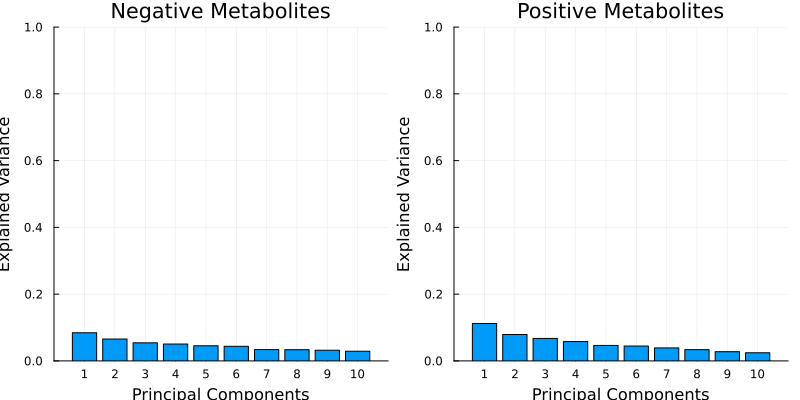

In [44]:
ticklabel = string.(collect(1:10))
pNegPCA =bar(explainedVarPCAneg, orientation=:v, xticks=(1:10, ticklabel),
    yflip=false, legend = false, title = "Negative Metabolites", ylims = (0, 1))
xlabel!("Principal Components")
ylabel!("Explained Variance");

pPosPCA =bar(explainedVarPCApos, orientation=:v, xticks=(1:10, ticklabel),
    yflip=false, legend = false, title = "Positive Metabolites", ylims = (0, 1))
xlabel!("Principal Components")
ylabel!("Explained Variance");

plot(pNegPCA, pPosPCA, size = (800, 400))

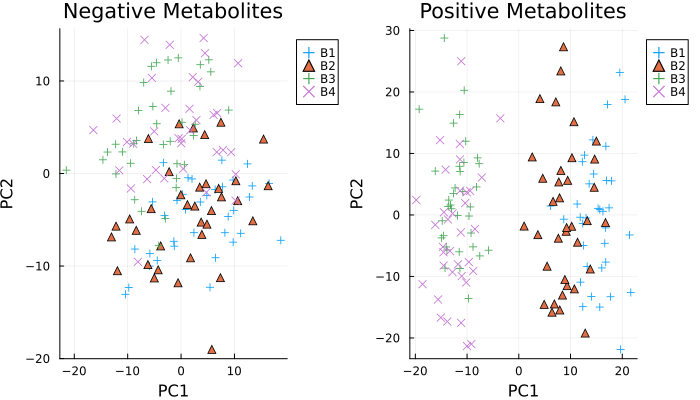

In [45]:
# get batch group labels
XbatchNeg = Vector(dfNeg[:,2]);
XbatchPos = Vector(dfPos[:,2]);

# apply PCA model 
Yneg = MultivariateStats.transform(Mneg, Xneg)
Ypos = MultivariateStats.transform(Mpos, Xpos)

# group results by testing set labels for color coding
B1neg = Yneg[:,XbatchNeg.=="B1"]; B1pos = Ypos[:,XbatchPos.=="B1"] 
B2neg = Yneg[:,XbatchNeg.=="B2"]; B2pos = Ypos[:,XbatchPos.=="B2"]
B3neg = Yneg[:,XbatchNeg.=="B3"]; B3pos = Ypos[:,XbatchPos.=="B3"]
B4neg = Yneg[:,XbatchNeg.=="B4"]; B4pos = Ypos[:,XbatchPos.=="B4"];

# visualize first 2 principal components
pNegScat = scatter(B1neg[1,:],B1neg[2,:], marker=:auto, markersize=4, linewidth=0, label = "B1")
scatter!(B2neg[1,:],B2neg[2,:], marker=:utriangle,linewidth=0, label = "B2")
scatter!(B3neg[1,:],B3neg[2,:], marker=:+,linewidth=0, label = "B3")
scatter!(B4neg[1,:],B4neg[2,:], marker=:x,linewidth=0, label = "B4")
plot!(pNegScat,xlabel="PC1",ylabel="PC2");

pPosScat = scatter(B1pos[1,:],B1pos[2,:], marker=:auto, markersize=4, linewidth=0, label = "B1")
scatter!(B2pos[1,:],B2pos[2,:], marker=:utriangle,linewidth=0, label = "B2")
scatter!(B3pos[1,:],B3pos[2,:], marker=:+,linewidth=0, label = "B3")
scatter!(B4pos[1,:],B4pos[2,:], marker=:x,linewidth=0, label = "B4")
plot!(pPosScat,xlabel="PC1",ylabel="PC2");

plot(pNegScat, pPosScat, legend = :outertopright, title = ["Negative Metabolites" "Positive Metabolites"], size = (700, 400))

### Lipids most influenced by batches

In [46]:
# Get variance explained
dfVarExplNeg = getVarExpl(Xneg, XbatchNeg, names(dfNeg)[6:end]);
dfVarExplPos = getVarExpl(Xpos, XbatchPos, names(dfPos)[6:end]);

In [47]:
first(dfVarExplNeg, 5)

Row,Lipids,VarExpl
,String,Float64
1,negMeta323,0.94102
2,negMeta125,0.923012
3,negMeta114,0.916264
4,negMeta765,0.901512
5,negMeta960,0.901315


In [48]:
first(dfVarExplPos, 5)

Row,Lipids,VarExpl
,String,Float64
1,posMeta1663,0.982033
2,posMeta1580,0.978721
3,posMeta1839,0.970537
4,posMeta1773,0.965097
5,posMeta1248,0.956792


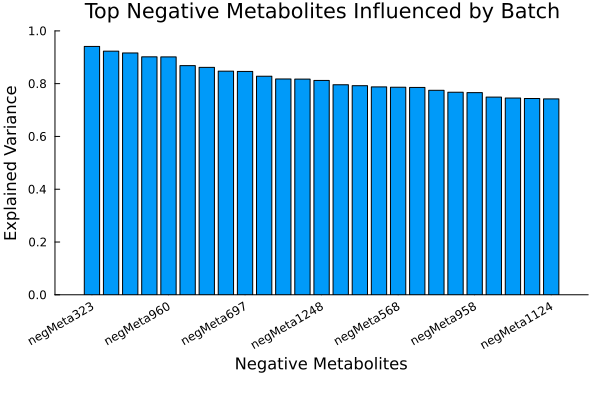

In [49]:
nTop = 25# sum(dfVarExpl.VarExpl>0.1)

ticklabel = dfVarExplNeg.Lipids[1:nTop]
pNeg =bar(
    dfVarExplNeg.VarExpl[1:nTop], 
    orientation=:v, 
    xticks=(1:4:nTop, ticklabel[1:4:nTop]),
    xrotation= 30,
    yflip=false, grid = false, 
    legend = false, 
    title = "Top Negative Metabolites Influenced by Batch", 
    ylims = (0, 1),
    bottom_margin = (10, :mm)
)
xlabel!("Negative Metabolites")
ylabel!("Explained Variance")

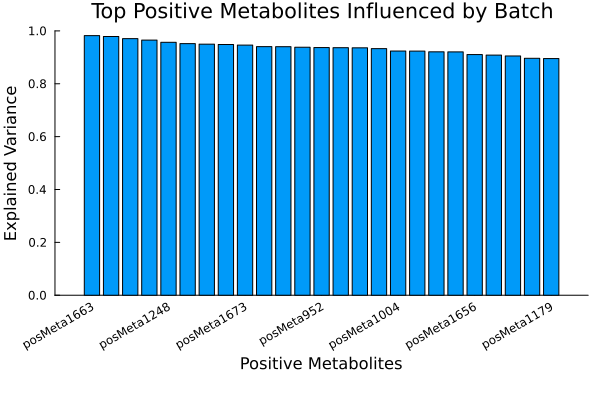

In [50]:
ticklabel = dfVarExplPos.Lipids[1:nTop]
pPos =bar(
    dfVarExplPos.VarExpl[1:nTop], 
    orientation=:v, 
    xticks=(1:4:nTop, ticklabel[1:4:nTop]),
    xrotation = 30,
    yflip=false, 
    legend = false, grid = false, 
    title = "Top Positive Metabolites Influenced by Batch", 
    ylims = (0, 1),
    bottom_margin = (10, :mm)
)
xlabel!("Positive Metabolites")
ylabel!("Explained Variance")

### Most influential batch 

In [51]:
adjRsquaredPerLipidsPerBatch = getVarExplPerMetaPerBatch(Xneg, XbatchNeg, dfVarExplNeg.Lipids); 

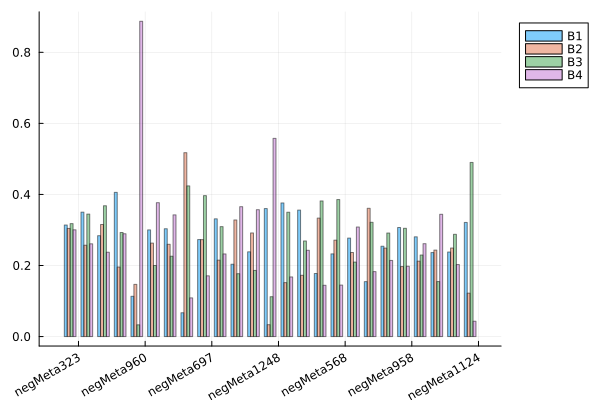

In [52]:
ticklabel = dfVarExplNeg.Lipids[1:nTop]
groupedbar(ticklabel, adjRsquaredPerLipidsPerBatch[1:nTop, :], 
    bar_position = :dodge, bar_width=0.7, alpha=0.5,
    xticks=(1:4:nTop, ticklabel[1:4:nTop]), xrotation = 30,
    legend = :outertopright, label = ["B1" "B2" "B3" "B4"]
)

In [53]:
size(dfNeg)

(142, 1256)

## Correct batch effect with combat 

In [54]:
R"""
suppressMessages(library(sva))
fCombat <- function(myDf){
mLipids <- as.matrix(myDf[,c(-1,-2,-3,-4,-5)])

modcombat <- model.matrix(~1, data = myDf[,c(2,3,5)])

combatLipids <- ComBat(dat=t(mLipids), batch = myDf$Batch, mod=modcombat, par.prior=TRUE, prior.plots=FALSE)

# modGroupFishOil <- model.matrix(~Group*FishOil, data = myDf[,c(2,3,5)])
# combatFit = lm.fit(modGroupFishOil, t(combatLipids))

return(combatLipids)
}

mLipidsBatchAdjNeg <- t(fCombat(dfNeg));
mLipidsBatchAdjPos <- t(fCombat(dfPos));

"""
@rget mLipidsBatchAdjNeg;
@rget mLipidsBatchAdjPos;

┌ Warning: RCall.jl: Found4batches
│ Adjusting for0covariate(s) or covariate level(s)
│ Standardizing Data across genes
│ Fitting L/S model and finding priors
│ Finding parametric adjustments
│ Adjusting the Data
│ 
└ @ RCall /home/gregfa/.julia/packages/RCall/LWzAQ/src/io.jl:172
┌ Warning: RCall.jl: Found4batches
│ Adjusting for0covariate(s) or covariate level(s)
│ Standardizing Data across genes
│ Fitting L/S model and finding priors
│ Finding parametric adjustments
│ Adjusting the Data
│ 
└ @ RCall /home/gregfa/.julia/packages/RCall/LWzAQ/src/io.jl:172


In [55]:
# get matrix data
Xneg= copy(transpose(mLipidsBatchAdjNeg));
Xpos= copy(transpose(mLipidsBatchAdjPos));

# train a PCA model
Mneg = fit(PCA, Xneg; maxoutdim=10)
Mpos = fit(PCA, Xpos; maxoutdim=10);

In [56]:
size(Xneg)

(1251, 142)

In [57]:
# get explained variance
explainedVarPCAneg = principalvars(Mneg)./tvar(Mneg)
explainedVarPCApos = principalvars(Mpos)./tvar(Mpos);

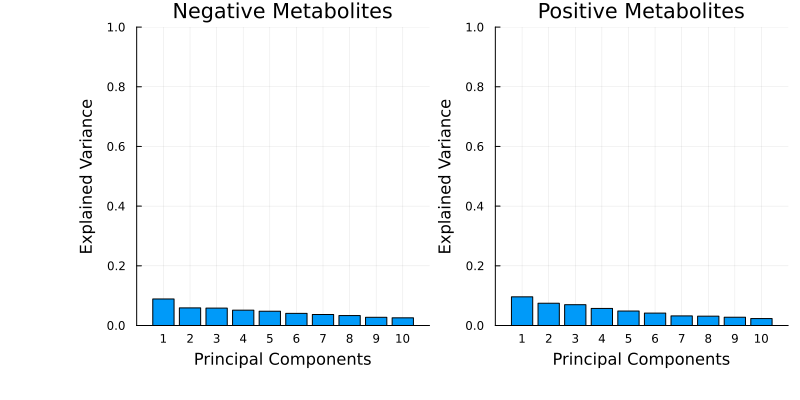

In [58]:
ticklabel = string.(collect(1:10))
pNegPCAAdj =bar(
    explainedVarPCAneg, orientation=:v, xticks=(1:10, ticklabel),
    yflip=false, legend = false, title = "Negative Metabolites", 
    ylims = (0, 1),
    left_margin = (22, :mm),
    bottom_margin = (10, :mm),
)
xlabel!("Principal Components")
ylabel!("Explained Variance");

pPosPCAAdj =bar(
    explainedVarPCApos, orientation=:v, xticks=(1:10, ticklabel),
    yflip=false, legend = false, title = "Positive Metabolites", 
    ylims = (0, 1),
    bottom_margin = (10, :mm)
)
xlabel!("Principal Components")
ylabel!("Explained Variance");

plot(
    pNegPCAAdj, pPosPCAAdj, 
    size = (800, 400),    
)

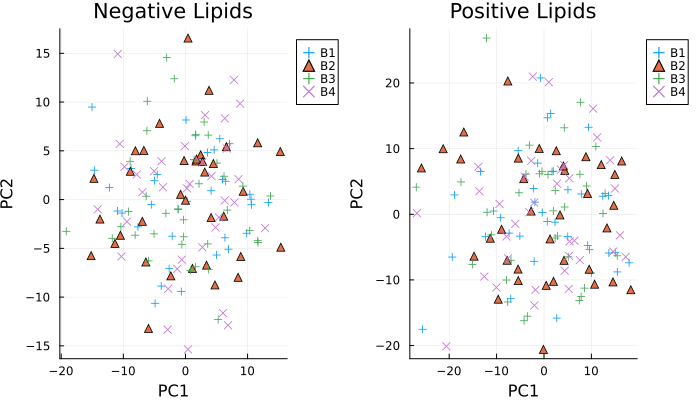

In [59]:
# get batch group labels
XbatchNeg = Vector(dfNeg[:,2]);
XbatchPos = Vector(dfPos[:,2]);

# apply PCA model 
Yneg = MultivariateStats.transform(Mneg, Xneg)
Ypos = MultivariateStats.transform(Mpos, Xpos)

# group results by testing set labels for color coding
B1neg = Yneg[:,XbatchNeg.=="B1"]; B1pos = Ypos[:,XbatchPos.=="B1"] 
B2neg = Yneg[:,XbatchNeg.=="B2"]; B2pos = Ypos[:,XbatchPos.=="B2"]
B3neg = Yneg[:,XbatchNeg.=="B3"]; B3pos = Ypos[:,XbatchPos.=="B3"]
B4neg = Yneg[:,XbatchNeg.=="B4"]; B4pos = Ypos[:,XbatchPos.=="B4"];

# visualize first 2 principal components
pNegScatAdj = scatter(B1neg[1,:],B1neg[2,:], marker=:auto, markersize=4, linewidth=0, label = "B1")
scatter!(B2neg[1,:],B2neg[2,:], marker=:utriangle,linewidth=0, label = "B2")
scatter!(B3neg[1,:],B3neg[2,:], marker=:+,linewidth=0, label = "B3")
scatter!(B4neg[1,:],B4neg[2,:], marker=:x,linewidth=0, label = "B4")
plot!(pNegScatAdj,xlabel="PC1",ylabel="PC2");

pPosScatAdj = scatter(B1pos[1,:],B1pos[2,:], marker=:auto, markersize=4, linewidth=0, label = "B1")
scatter!(B2pos[1,:],B2pos[2,:], marker=:utriangle,linewidth=0, label = "B2")
scatter!(B3pos[1,:],B3pos[2,:], marker=:+,linewidth=0, label = "B3")
scatter!(B4pos[1,:],B4pos[2,:], marker=:x,linewidth=0, label = "B4")
plot!(pPosScatAdj,xlabel="PC1",ylabel="PC2");

plot(pNegScatAdj, pPosScatAdj, legend = :outertopright, title = ["Negative Lipids" "Positive Lipids"], size = (700, 400))

### Metabolites most influenced by batches after correction

In [60]:
# Get variance explained
dfVarExplNeg = getVarExpl(Xneg, XbatchNeg, names(dfNeg)[6:end]);
dfVarExplPos = getVarExpl(Xpos, XbatchPos, names(dfPos)[6:end]);

In [61]:
first(dfVarExplNeg, 5)

Row,Lipids,VarExpl
,String,Float64
1,negMeta323,0.0848483
2,negMeta960,0.0597171
3,negMeta125,0.0555615
4,negMeta114,0.0488235
5,negMeta765,0.0361576


In [62]:
first(dfVarExplPos, 5)

Row,Lipids,VarExpl
,String,Float64
1,posMeta1663,0.0757551
2,posMeta1580,0.059548
3,posMeta1839,0.041922
4,posMeta1773,0.023622
5,posMeta1248,0.0152308


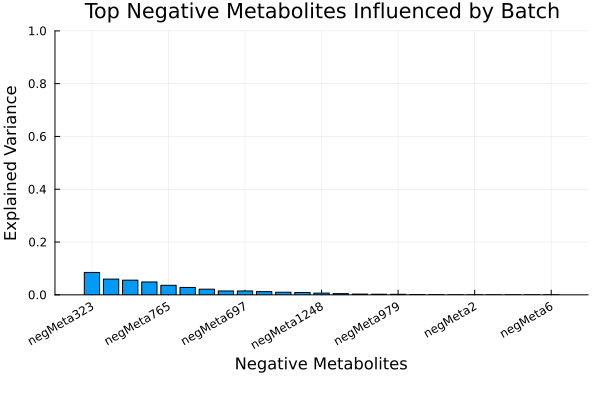

In [63]:
nTop = 25# sum(dfVarExpl.VarExpl>0.1)

ticklabel = dfVarExplNeg.Lipids[1:nTop]
pNegAdj =bar(
    dfVarExplNeg.VarExpl[1:nTop], 
    orientation=:v, 
    xticks=(1:4:nTop, ticklabel[1:4:nTop]),
    xrotation = 30,
    yflip=false, 
    legend = false, 
    title = "Top Negative Metabolites Influenced by Batch", 
    ylims = (0, 1), 
    bottom_margin = (10, :mm)
)
xlabel!("Negative Metabolites")
ylabel!("Explained Variance")

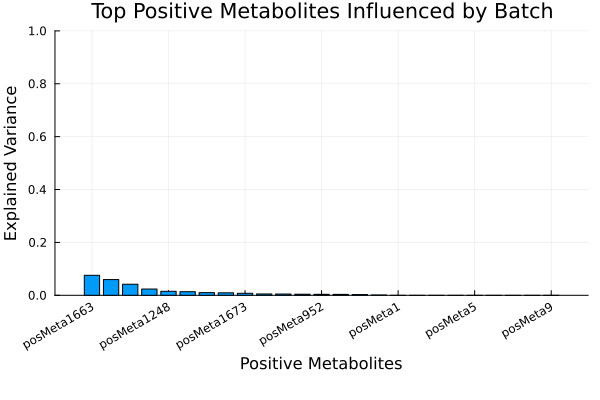

In [64]:
ticklabel = dfVarExplPos.Lipids[1:nTop]
pPosAdj =bar(
    dfVarExplPos.VarExpl[1:nTop], 
    orientation=:v, 
    xticks=(1:4:nTop, ticklabel[1:4:nTop]),
    xrotation = 30,
    yflip=false, 
    legend = false, 
    title = "Top Positive Metabolites Influenced by Batch", 
    ylims = (0, 1),
    bottom_margin = (10, :mm),
)
xlabel!("Positive Metabolites")
ylabel!("Explained Variance")

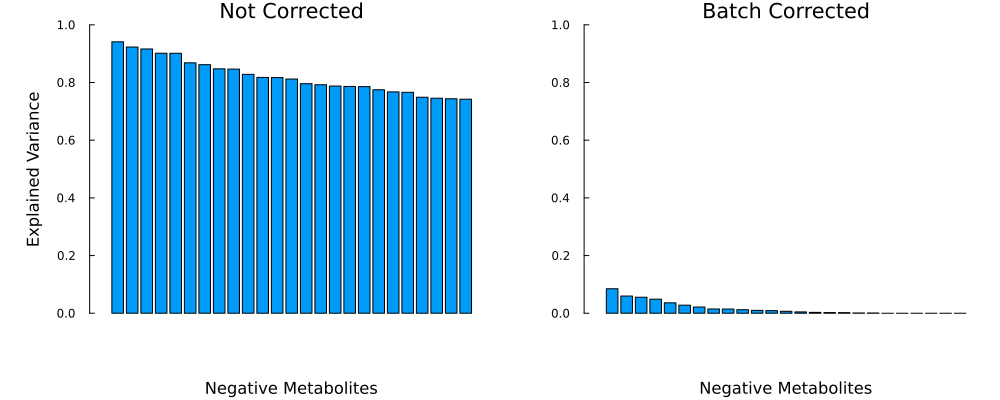

In [65]:
plot(pNeg, pNegAdj,
    legend = :false, 
    grid = false, 
    title = ["Not Corrected" "Batch Corrected"],
    ylabel = ["Explained Variance" ""],
    xaxis = false,
    left_margin = (10, :mm),
    bottom_margin = (10, :mm),
    size = (1000, 400)
)

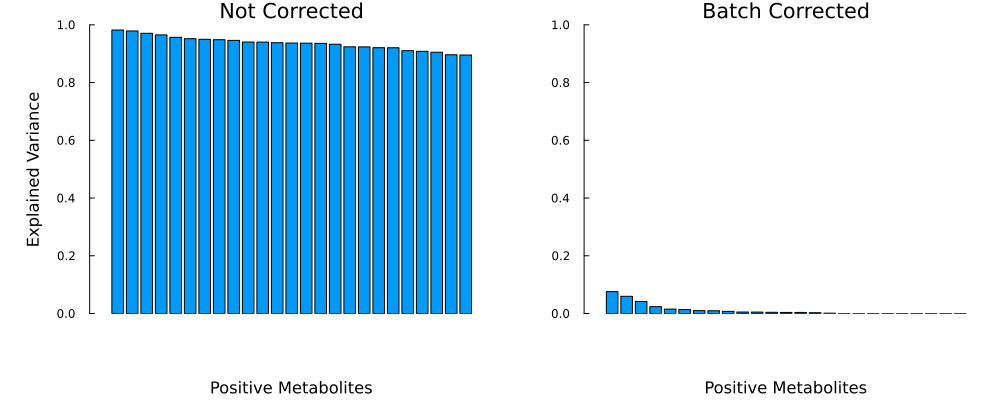

In [66]:
plot(pPos, pPosAdj,
    legend = :false, 
    grid = false, 
    title = ["Not Corrected" "Batch Corrected"],
    ylabel = ["Explained Variance" ""],
    xaxis = false,
    left_margin = (10, :mm),
    bottom_margin = (10, :mm),
    size = (1000, 400)
)

We use the F-test from `GLM.jl` to confirm with adjusted p-value that the batch effects has been corrected but the Combat methods. 

- Negative Lipids:

In [67]:
n = size(Xneg)[1]

adjPval = zeros(n)

for i in 1:n
    dftest = DataFrame(X = CategoricalArray(string.(XbatchNeg)), Y = Xneg[i,:])
    out = lm(@formula(Y ~ X), dftest);
    out0 = lm(@formula(Y ~ 1), dftest);
    my_ftest=ftest(out0.model, out.model)
    adjPval[i] = my_ftest.pval[2]
end

R"""
suppressMessages(library(stats))
suppressMessages(library(qvalue));
"""
@rput adjPval;

R"""
qobj <- qvalue(p = adjPval)
qVals <- qobj$qvalues;
"""
@rget qVals;

describe(qVals)

Summary Stats:
Length:         1251
Missing Count:  0
Mean:           0.999997
Minimum:        0.999997
1st Quartile:   0.999997
Median:         0.999997
3rd Quartile:   0.999997
Maximum:        0.999997
Type:           Float64


- Positive Lipids

In [68]:
n = size(Xpos)[1]

adjPval = zeros(n)

for i in 1:n
    dftest = DataFrame(X = CategoricalArray(string.(XbatchPos)), Y = Xpos[i,:])
    out = lm(@formula(Y ~ X), dftest);
    out0 = lm(@formula(Y ~ 1), dftest);
    my_ftest=ftest(out0.model, out.model)
    adjPval[i] = my_ftest.pval[2]
end

R"""
suppressMessages(library(stats))
suppressMessages(library(qvalue));
"""
@rput adjPval;

R"""
qobj <- qvalue(p = adjPval)
qVals <- qobj$qvalues;
"""
@rget qVals;

describe(qVals)

Summary Stats:
Length:         1867
Missing Count:  0
Mean:           1.000000
Minimum:        1.000000
1st Quartile:   1.000000
Median:         1.000000
3rd Quartile:   1.000000
Maximum:        1.000000
Type:           Float64


## Save pretreatments

In [69]:
dfNegMeta[:, 6:end] = mLipidsBatchAdjNeg;
dfPosMeta[:, 6:end] = mLipidsBatchAdjPos;

In [70]:
println(string("Number of Missing for Neg: " , 
        length(findall(Matrix(dfNegMeta[:,6:end]) .=== missing))))
println(string("Number of Missing for Pos: " , 
        length(findall(Matrix(dfPosMeta[:,6:end]) .=== missing))))   

Number of Missing for Neg: 0
Number of Missing for Pos: 0


In [71]:
dfNegMeta |> CSV.write("../../data/data_processed/inl2b_NegMeta.csv")

"../../data/data_processed/inl2b_NegMeta.csv"

In [72]:
dfPosMeta |> CSV.write("../../data/data_processed/inl2b_PosMeta.csv")

"../../data/data_processed/inl2b_PosMeta.csv"

In [73]:
dfNegMeta[80:100,:]

Row,Sample,Batch,Group,Statin,FishOil,negMeta1,negMeta2,negMeta3,negMeta4,negMeta5,negMeta6,negMeta7,negMeta8,negMeta9,negMeta10,negMeta11,negMeta12,negMeta13,negMeta14,negMeta15,negMeta16,negMeta17,negMeta18,negMeta19,negMeta20,negMeta21,negMeta22,negMeta23,negMeta24,negMeta25,negMeta26,negMeta27,negMeta28,negMeta29,negMeta30,negMeta31,negMeta32,negMeta33,negMeta34,negMeta35,negMeta36,negMeta37,negMeta38,negMeta39,negMeta40,negMeta41,negMeta42,negMeta43,negMeta44,negMeta45,negMeta46,negMeta47,negMeta48,negMeta49,negMeta50,negMeta51,negMeta52,negMeta53,negMeta54,negMeta55,negMeta56,negMeta57,negMeta58,negMeta59,negMeta60,negMeta61,negMeta62,negMeta63,negMeta64,negMeta65,negMeta66,negMeta67,negMeta68,negMeta69,negMeta70,negMeta71,negMeta72,negMeta73,negMeta74,negMeta75,negMeta76,negMeta77,negMeta78,negMeta79,negMeta80,negMeta81,negMeta82,negMeta83,negMeta84,negMeta85,negMeta86,negMeta87,negMeta88,negMeta89,negMeta90,negMeta91,negMeta92,negMeta93,negMeta94,negMeta95,⋯
,String31,Cat…,Cat…,Cat…,Cat…,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,⋯
1,QE2_jdg_291_Elam_80[CN42]n,B2,CN,yes,no,-8.25866,-9.23093,-7.33214,-8.73396,-8.9855,-7.88009,-8.81162,-8.258,-7.76048,-6.96624,-8.62014,-9.5068,-8.52724,-7.44196,-9.96337,-9.46135,-8.84921,-7.74362,-6.06336,-8.1901,-7.88069,-8.83447,-6.65868,-9.21691,-7.93699,-7.84621,-6.55443,-8.60332,-7.18969,-7.01983,-7.26173,-7.80892,-8.38933,-8.28669,-7.84023,-7.7656,-7.35415,-6.19694,-7.65279,-7.09434,-6.82019,-7.97369,-6.92146,-7.77654,-6.76883,-8.50479,-7.16596,-7.43183,-4.27074,-6.43482,-7.2402,-6.94649,-6.92632,-6.81716,-4.16921,-6.82819,-5.34346,-5.266,-6.97655,-3.89496,-6.05357,-3.88957,-4.41685,-5.61552,-4.49916,-6.72599,-2.62017,-5.46846,-5.07051,-5.2885,-5.01696,-6.17502,-5.27318,-5.65512,-6.65435,-5.94116,-5.29492,-6.16059,-6.58169,-4.52346,-4.61389,-4.6991,-3.59519,-4.53959,-5.34765,-4.34368,-3.8299,-4.94695,-3.24832,-4.99294,-4.34073,-5.42347,-3.22264,-5.43356,-5.69417,⋯
2,QE2_jdg_292_Elam_81[CN43]n,B3,CN,yes,no,-8.66969,-10.5028,-8.26837,-8.23037,-8.73991,-8.46124,-8.86537,-9.10735,-8.16682,-7.88628,-8.55945,-8.50541,-8.58534,-7.91081,-9.39218,-8.43811,-8.40833,-7.58064,-6.13537,-7.15811,-7.33075,-10.0206,-6.12017,-7.50084,-8.05633,-7.75066,-5.74642,-9.67949,-6.0546,-6.03822,-7.03028,-7.35012,-7.70626,-8.29207,-7.44767,-7.2101,-8.02148,-6.29521,-7.63874,-7.13495,-6.32166,-7.82825,-6.27404,-7.33801,-6.90911,-1.36923,-7.21129,-6.15997,-5.31485,-6.55349,-8.64971,-7.43424,-8.0143,-6.47328,-4.56962,-7.08969,-5.92912,-4.79025,-7.33192,-6.1664,-5.22284,-4.56777,-5.90537,-5.79653,-5.6264,-5.81797,-7.59059,-5.11285,-5.32303,-5.84063,-5.28941,-6.20872,-4.90747,-6.26151,-1.96547,-5.19765,-4.84429,-5.29064,-4.44968,-9.66246,-5.51237,-4.70554,-4.28231,-4.95403,-5.56422,-4.21275,-2.35853,-2.45866,-4.84513,-4.88659,-4.12693,-5.35696,-2.65405,-4.2055,2.29659,⋯
3,QE2_jdg_292_Elam_82[CN44]n,B3,CN,yes,no,-8.21481,-10.355,-7.85849,-9.19246,-9.7418,-8.19747,-8.58145,-8.55129,-8.13981,-8.86606,-7.85438,-8.48568,-7.88797,-7.70537,-9.51939,-8.41641,-8.27897,-7.89978,-7.55926,-7.05389,-7.38515,-8.41831,-7.45014,-8.72907,-8.01321,-7.55293,-7.49961,-7.98177,-7.82309,-8.11266,-7.5883,-8.55376,-8.60213,-8.21061,-6.952,-8.53659,-8.33065,-6.75421,-7.70691,-5.9622,-6.86825,-7.51609,-7.01479,-7.47066,-6.20553,-1.7047

In [74]:
first(dfPosMeta,3)

Row,Sample,Batch,Group,Statin,FishOil,posMeta1,posMeta2,posMeta3,posMeta4,posMeta5,posMeta6,posMeta7,posMeta8,posMeta9,posMeta10,posMeta11,posMeta12,posMeta13,posMeta14,posMeta15,posMeta16,posMeta17,posMeta18,posMeta19,posMeta20,posMeta21,posMeta22,posMeta23,posMeta24,posMeta25,posMeta26,posMeta27,posMeta28,posMeta29,posMeta30,posMeta31,posMeta32,posMeta33,posMeta34,posMeta35,posMeta36,posMeta37,posMeta38,posMeta39,posMeta40,posMeta41,posMeta42,posMeta43,posMeta44,posMeta45,posMeta46,posMeta47,posMeta48,posMeta49,posMeta50,posMeta51,posMeta52,posMeta53,posMeta54,posMeta55,posMeta56,posMeta57,posMeta58,posMeta59,posMeta60,posMeta61,posMeta62,posMeta63,posMeta64,posMeta65,posMeta66,posMeta67,posMeta68,posMeta69,posMeta70,posMeta71,posMeta72,posMeta73,posMeta74,posMeta75,posMeta76,posMeta77,posMeta78,posMeta79,posMeta80,posMeta81,posMeta82,posMeta83,posMeta84,posMeta85,posMeta86,posMeta87,posMeta88,posMeta89,posMeta90,posMeta91,posMeta92,posMeta93,posMeta94,posMeta95,⋯
,String31,Cat…,Cat…,Cat…,Cat…,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,⋯
1,QE2_jdg_290_Elam_1[CN01]p,B1,CN,yes,yes,-13.8517,-12.1536,-10.077,-9.62404,-11.268,-10.2241,-5.27433,-7.97686,-8.68245,-9.81145,-10.6335,-9.91327,-9.76174,-9.33919,-10.2486,-8.82761,-9.35658,-10.8714,-8.29636,-10.3934,-13.1468,-11.2666,-9.18472,-10.581,-10.2885,-9.6102,-10.0724,-8.56326,-7.35913,-7.09597,-8.8203,-11.4954,-9.50271,-9.35743,-9.8373,-8.89889,-8.64022,-8.05882,-9.95975,-7.7959,-11.1148,-8.65355,-8.5931,-9.52606,-9.93763,-10.0016,-8.38691,-6.77934,-8.32534,-6.87557,-9.32414,-9.02546,-9.41913,-8.89842,-7.86704,-8.42588,-8.69589,-8.94288,-7.76769,-8.09584,-7.88328,-9.30347,-9.32307,-8.92409,-4.99647,-5.5876,-7.65237,-8.88423,-8.59737,-8.67231,-8.52618,-8.22779,-8.39211,-8.79977,-7.87786,-7.41652,-7.48108,-8.92157,-8.259,-7.85421,-7.89799,-8.70238,-6.45205,-7.77164,-8.40945,-7.59263,-6.1518,-7.26302,-7.43112,-7.18012,-7.53884,-8.12977,-7.26224,-7.54142,-6.28938,⋯
2,QE2_jdg_292_Elam_2[CN02]p,B3,CN,yes,yes,-9.88996,-12.8306,-10.3946,-9.24193,-11.0303,-8.96926,-11.9776,-8.06457,-10.588,-7.7131,-10.357,-9.16818,-11.0348,-10.1606,-10.8882,-9.44677,-9.67291,-10.9733,-7.74464,-10.4578,-5.81357,-10.551,-8.03047,-11.5687,-10.3053,-11.6521,-9.71659,-11.0802,-7.48223,-8.67837,-8.21488,-10.6719,-9.99184,-8.29613,-14.7411,-10.7815,-8.67827,-7.21084,-9.72021,-8.54557,-10.0351,-10.1656,-8.82574,-9.58639,-10.3201,-9.66,-9.35928,-7.30773,-9.32528,-9.1116,-8.55126,-6.20023,-9.60184,-8.62798,-9.09233,-8.4345,-8.98106,-9.16547,-8.97559,-15.1865,-8.78403,-9.56308,-8.74157,-9.0935,-9.54281,-6.11972,-7.68441,-8.94695,-7.16993,-9.36051,-7.90107,-8.48617,-7.23327,-8.07249,-7.63286,-5.99205,-6.88493,-8.5604,-7.53388,-8.15848,-7.32868,-8.11613,-9.48662,-8.3638,-8.35215,-8.56206,-7.37296,-8.25749,-7.70051,-8.64895,-7.50155,-8.71918,-7.70929,-8.14043,-9.09304,⋯
3,QE2_jdg_291_Elam_3[CN03]p,B2,CN,yes,yes,-11.7315,-12.3501,-8.07045,-13.3663,-11.5239,-8.3005,-11.8139,-9.16432,-8.60298,-12.2231,-10.9188,-10.6087,-9.06339,-9.81454,-11.2621,-9.90034,-10.5342,-10.7964,-9.13952,-10.6122,-7.68285,-10.4862,-7.27228,-9.96689,-9.41461,-11.3216,-10.1137,-9.10645,-7.18329,-10.3837,-9.42438,-10.4437,-10.6344,-9.90392,-8.2398,-10.298,-8.86249,-8.48891,-10.3061,-8.52901,-9.89681,-9.71239,-8.06535,-9.70036,-10.9281,-9.7289,-

In [75]:
# Join negative and positive lipids data frames

# Keep only "[ ]" and ID inside bracket:
for i in 1:size(dfNegMeta)[1]
    dfNegMeta.Sample[i]=  dfNegMeta.Sample[i][end-6:end-1]
    dfPosMeta.Sample[i]=  dfPosMeta.Sample[i][end-6:end-1]
end

# join
# difference is due to CN04 and CN05 inversion 
# dfMeta = leftjoin(dfNegMeta, dfPosMeta[:, [1;4; collect(6:end)]], on = [:Sample, :Statin]);
dfMeta = leftjoin(dfPosMeta, dfNegMeta[:, [1;4; collect(6:end)]], on = [:Sample, :Statin]);

In [76]:
println(string("Number of Missing for Meta: " , 
        length(findall(Matrix(dfMeta[:,6:end]) .=== missing))))

Number of Missing for Meta: 0


In [77]:
dfMeta |> CSV.write("../../data/data_processed/inl2b_Meta.csv")

"../../data/data_processed/inl2b_Meta.csv"

In [78]:
versioninfo()

Julia Version 1.8.5
Commit 17cfb8e65ea (2023-01-08 06:45 UTC)
Platform Info:
  OS: Linux (x86_64-linux-gnu)
  CPU: 4 × Intel(R) Core(TM) i7-2640M CPU @ 2.80GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-13.0.1 (ORCJIT, sandybridge)
  Threads: 1 on 4 virtual cores
Environment:
  LD_GOLD = /home/gregfa/softwares/miniconda3/envs/r2d2/bin/x86_64-conda-linux-gnu-ld.gold


In [79]:
R"""
sessionInfo()
"""

RObject{VecSxp}
R version 4.1.2 (2021-11-01)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 22.04.1 LTS

Matrix products: default
BLAS/LAPACK: /home/gregfa/softwares/miniconda3/envs/r2d2/lib/libopenblasp-r0.3.21.so

locale:
 [1] LC_CTYPE=en_US.UTF-8          LC_NUMERIC=C                 
 [3] LC_TIME=en_US.UTF-8           LC_COLLATE=en_US.UTF-8       
 [5] LC_MONETARY=en_US.UTF-8       LC_MESSAGES=en_US.UTF-8      
 [7] LC_PAPER=en_US.UTF-8          LC_NAME=en_US.UTF-8          
 [9] LC_ADDRESS=en_US.UTF-8        LC_TELEPHONE=en_US.UTF-8     
[11] LC_MEASUREMENT=en_US.UTF-8    LC_IDENTIFICATION=en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] qvalue_2.26.0       sva_3.42.0          BiocParallel_1.28.3
 [4] genefilter_1.76.0   mgcv_1.8-42         nlme_3.1-162       
 [7] mixOmics_6.18.1     ggplot2_3.4.2       lattice_0.21-8     
[10] MASS_7.3-60        

loaded via a namespace 